In [1]:
import os
import torch
import torchaudio
torchaudio.set_audio_backend("sox_io")
import pandas as pd
import numpy as np
import torch.nn.functional as F
import random
import scipy
import math
from scipy import signal
import librosa.display
import torch.nn as nn
from torch.utils.data import DataLoader

GAMMA = 2.5
DATA = 'ravdess_LMS'
LAYERS = 3
ROOT = './Dataset/{}'.format(DATA)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
MODEL_PATH = './model/{}_DANN_{}L-CNN-GRU_DAP{}_CV'.format(DATA,LAYERS,GAMMA)
NPARR_PATH = './array/{}_DANN_{}L-CNN-GRU_DAP{}_CV accuracies.npz'.format(DATA,LAYERS,GAMMA)

/home/bryan/miniconda3/envs/FYP/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def set_seed(sd):
    np.random.seed(sd)
    random.seed(sd)
    random.Random(sd)
    torch.manual_seed(sd)
    torch.cuda.manual_seed(sd)
    torch.cuda.manual_seed_all(sd)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print("Seed set to:{}".format(sd))
# also set worker_init_fn=np.random.seed(0),num_workers=0 in dataloader   

set_seed(42)

Seed set to:42


## 1. CV Dataset for Ravdess

In [3]:
class RavdessDataset2(object):
    """
        Create a Dataset for RAVDESS. Each item is a tuple of the form:
        (feature, emotion, speaker)
    """ 
    
    # Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
    _emotions = { '01': 0, '02': 1, '03': 2, '04': 3, '05': 4, '06': 5, '07': 6, '08': 7 }
 
    _speaker = {'0'+ str(i+1): i for i in range(24) if i< 9}
    _speaker.update({str(i+1): i for i in range(24) if i>= 9})

    
    def __init__(self, root, cv_index, split):
        """
        Args:
            root (string): Directory containing the wav files
            split(string): Either train, validate or test set
        """
        self.root = root
        self.data = []
        self.df = pd.DataFrame(self.data, columns=['Speaker', 'Emotion', 'File'])
        self.allActors = ['0'+ str(i+1) for i in range(24)if i<9] + [str(i+1) for i in range(24)if i>=9]
        
        self.cv = { 0:  (['01','02'],['03','04']),
                    1:  (['03','04'],['05','06']),
                    2:  (['05','06'],['07','08']),
                    3:  (['07','08'],['09','10']),
                    4:  (['09','10'],['11','12']),
                    5:  (['11','12'],['13','14']),
                    6:  (['13','14'],['15','16']),
                    7:  (['15','16'],['17','18']),
                    8:  (['17','18'],['19','20']),
                    9:  (['19','20'],['21','22']),
                    10: (['21','22'],['23','24']),
                    11: (['23','24'],['01','02'])
                  }

        # Iterate through all audio files
        for root, dirs, files in os.walk(root):
            for file in files: 
                
                if split == 'train':
                    if file[-5:-3] in [x for x in self.allActors if x not in (self.cv[cv_index][0]+ self.cv[cv_index][1])]:
                        self.data.append([file[-5:-3],file[6:8],file])
                        
                elif split == 'validate':
                    if file[-5:-3] in self.cv[cv_index][0]:
                        self.data.append([file[-5:-3],file[6:8],file])
                        
                elif split == 'test':
                    if file[-5:-3] in self.cv[cv_index][1]:
                        self.data.append([file[-5:-3],file[6:8],file])
                else:
                    print("Error: Split can only be train, validate or test!")

        # Convert data to pandas dataframe
        self.df = pd.DataFrame(self.data, columns=['Speaker', 'Emotion', 'File'])

        # Map emotion labels to numeric values
        self.df['Emotion'] = self.df['Emotion'].map(self._emotions).astype(np.long)
        self.df['Speaker'] = self.df['Speaker'].map(self._speaker).astype(np.long)

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):

        file_name = os.path.join(self.root, self.df.loc[idx, 'File'])
        feature = torch.load(file_name )
        emotion = self.df.loc[idx, 'Emotion']
        speaker = self.df.loc[idx, 'Speaker']
        
        # return a tuple instead of a dictionary
        sample = (feature,emotion,speaker)

        return sample

In [4]:
# # Initialize RavdessDataset
# ravdess_dataset_train = RavdessDataset2(ROOT,cv_index = 4,split= 'train')
# ravdess_dataset_test = RavdessDataset2(ROOT,cv_index = 4,split= 'test')
# ravdess_dataset_validate = RavdessDataset2(ROOT,cv_index = 4, split= 'validate')

# # To view dataframe, uncomment below: 
# ravdess_dataset_train.df

In [5]:
# from torch.utils.data import DataLoader
# TRAIN_BATCH_SIZE = 16
# VALIDATE_BATCH_SIZE = len(ravdess_dataset_validate)
# TEST_BATCH_SIZE = len(ravdess_dataset_test)
# ravdess_train_loader = DataLoader(dataset=ravdess_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=2, pin_memory=True)
# ravdess_validate_loader = DataLoader(dataset=ravdess_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=2, pin_memory=True)
# ravdess_test_loader = DataLoader(dataset=ravdess_dataset_test, batch_size= TEST_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=2, pin_memory=True)

In [6]:
# next(iter(ravdess_train_loader))

## 2. Network Architectures and Helper Functions

### 2.1 Network Architectures

In [7]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        # For same padding, P = ((S-1)*W-S+F)/2, with F = filter size, S = stride. If stride = 1, P = (F-1)/2
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(2, 2),padding=1,bias=False),  
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(2, 2),padding=1,bias= False),  
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(2, 2),padding=1,bias=False),  
            nn.BatchNorm2d(128),
            nn.Dropout2d(p=0.1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
                     
        )
        
        self.GRU = nn.GRU(input_size= 2048, hidden_size = 256 ,batch_first = True, bidirectional = True) #128
        self.global_average_pooling = nn.AdaptiveAvgPool2d((8,8))
        self.FC = nn.Linear(in_features = 8 * 8, out_features = 512) 
        
        
    def forward(self,x):
        x = self.conv_layers(x)
        # print("1-LFLB shape: {}".format(x.shape))                     # batch_size, c_out, freq, time since we are using spectogram
        x = x.view(x.size(0),-1,x.size(3)) 
        # print("Batch size, features, seq shape: {}".format(x.shape))  # batch_size, features= c_out* freq , seq_len= time
        x = x.permute(0,2,1)
        # print("Batch size, seq, features shape: {}".format(x.shape))  # batch_size, seq, features
        output, hn = self.GRU(x)
        # print("GRU output shape: {}".format(output.shape))                # batch_size, seq, hidden size * 2 
        x = self.global_average_pooling(output)
        # print("Shape after global average pooling:{}".format(x.shape))
        x = torch.flatten(x,start_dim=1)
        # print("Shape after flattening:{}".format(x.shape))
        x = self.FC(x)
        # print("FC shape: {}".format(x.shape))

        return x


In [8]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier,self).__init__()
        self.label_classifier = nn.Sequential(
            
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 8),

        )
        
    def forward(self,x):
        x = self.label_classifier(x)
        return F.softmax(x)


In [9]:
class SpeakerClassifier(nn.Module):
    def __init__(self):
        super(SpeakerClassifier,self).__init__()
        self.label_classifier = nn.Sequential(
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 24),
        )
        
    def forward(self,x):
        x = self.label_classifier(x)
        return F.softmax(x)


### 2.2 Helper Functions

In [10]:
import numpy as np

def domain_adaptation_parameter(p):
    lambda_p = 2. / (1. + np.exp(-GAMMA*p)) - 1
    return lambda_p

In [11]:
def save_parameters(PATH):
    torch.save({
                'encoder_state_dict': encoder.state_dict(),
                'emotion_classifier_state_dict': emotion_classifier.state_dict(),
                'speaker_classifier_state_dict': speaker_classifier.state_dict(),
                'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
                'emotion_optimizer_state_dict': emotion_optimizer.state_dict(),
                'speaker_optimizer_state_dict': speaker_optimizer.state_dict(),
                }, PATH)
    print("Models' parameters and optimisers' parameters saved.")

In [12]:
def save_accuracies_and_losses(PATH):
    np.savez(PATH, 
         emoClassLoss = fold_emotion_class_losses,
         emoTrain_acc = fold_emotion_training_accuracies, 
         emoValidate_acc = fold_emotion_validating_accuracies,
         spkClassLoss = fold_speaker_class_losses,
         spkTrain_acc = fold_speaker_training_accuracies,
         spkValidate_acc = fold_speaker_validating_accuracies,
        
    )

## 4. Model Training

In [13]:
import warnings
warnings.filterwarnings('ignore')
import torch.optim as optim
import pylab as plt

# Read this to understand how GRL works: 
# https://christineai.blog/category/domain-adaptation/

FOLDS = 12
EPOCHS = 100

############### To comment this section out if disrupted #############
fold_emotion_class_losses = np.zeros((FOLDS,EPOCHS))
fold_emotion_training_accuracies = np.zeros((FOLDS,EPOCHS))
fold_emotion_validating_accuracies = np.zeros((FOLDS,EPOCHS))
fold_speaker_class_losses = np.zeros((FOLDS,EPOCHS))
fold_speaker_training_accuracies = np.zeros((FOLDS,EPOCHS))
fold_speaker_validating_accuracies = np.zeros((FOLDS,EPOCHS))


######### To uncomment if trying to continue disrupted training ######
# fold_emotion_class_losses, fold_emotion_training_accuracies, fold_emotion_validating_accuracies， fold_speaker_class_losses，fold_speaker_training_accuracies，fold_speaker_validating_accuracies= np.load(NPARR_PATH)

###################################################################

# 5-fold cross validation
for fold in range(0,FOLDS):

    # Selecting CPU or GPU
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # DEVICE = torch.device("cpu")

    # Selecting the type of encoder, label classifier
    encoder = FeatureExtractor().to(DEVICE).train()
    emotion_classifier = EmotionClassifier().to(DEVICE).train()
    speaker_classifier = SpeakerClassifier().to(DEVICE).train()
    
    encoder = nn.DataParallel(encoder)
    emotion_classifier = nn.DataParallel(emotion_classifier)
    speaker_classifier = nn.DataParallel(speaker_classifier)

    # Optimizer 
    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    emotion_optimizer = torch.optim.Adam(emotion_classifier.parameters())
    speaker_optimizer = torch.optim.Adam(speaker_classifier.parameters())

    cross_entropy_loss = nn.CrossEntropyLoss().to(DEVICE)
    
    ravdess_dataset_train = RavdessDataset2(ROOT,cv_index = fold ,split= 'train')
    ravdess_dataset_test = RavdessDataset2(ROOT,cv_index = fold, split= 'test')
    ravdess_dataset_validate = RavdessDataset2(ROOT,cv_index = fold, split= 'validate')
    
    # DANN should be trained on labelled data from the source domain and unlabelled data from the target domain
    TRAIN_BATCH_SIZE = 32
    ravdess_train_loader = DataLoader(dataset=ravdess_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=True,worker_init_fn=np.random.seed(42),num_workers=4, pin_memory= True)
    
    # For evaluation purposes
    VALIDATE_BATCH_SIZE = len(ravdess_dataset_validate)
    ravdess_validate_loader = DataLoader(dataset=ravdess_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=4, pin_memory= True)
    
    epoch_emotion_class_losses = []
    emotion_training_accuracies = []
    emotion_validating_accuracies = []

    epoch_speaker_class_losses = []
    speaker_training_accuracies = []
    speaker_validating_accuracies = []

    STEP = 0
    for epoch in range(EPOCHS):
        print("\nCurrent Fold: {} | Epoch: {}".format(fold, epoch))

        completed_start_steps = epoch * len(ravdess_train_loader)
        total_steps = EPOCHS * len(ravdess_train_loader)

        batch_emotion_class_losses = []
        batch_speaker_class_losses = []


        for batch_idx, (feature, emotion, speaker) in enumerate(ravdess_train_loader):

            # Assigned to DEVICE. 
            features, emotion, speaker = feature.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE)
            
            # Computing the training progress
            p = (batch_idx + completed_start_steps) / total_steps
            lambda_p = domain_adaptation_parameter(p)

            # Calculate speaker and emotion classification prediction 
            conv_features = encoder(features)
            emotion_preds = emotion_classifier(conv_features)
            emotion_class_loss = cross_entropy_loss(emotion_preds, emotion)
            speaker_preds = speaker_classifier(conv_features)
            speaker_class_loss = cross_entropy_loss(speaker_preds, speaker)

            # Calculate total loss
            total_loss = emotion_class_loss - lambda_p * speaker_class_loss 

            # Clear the gradient to prevent gradient accumulation
            encoder.zero_grad(set_to_none= True)
            emotion_classifier.zero_grad(set_to_none= True)
            speaker_classifier.zero_grad(set_to_none= True)

            # Computing the gradient
            total_loss.backward()

            # Update the weight
            emotion_optimizer.step()
            speaker_optimizer.step()
            encoder_optimizer.step()

            batch_emotion_class_losses.append(emotion_class_loss.detach())
            batch_speaker_class_losses.append(speaker_class_loss.detach())


        # Enter evaluation mode at the end of each epoch
        encoder.eval()
        emotion_classifier.eval()
        speaker_classifier.eval()

        emotion_training_correct, emotion_validating_correct, speaker_training_correct, speaker_validating_correct = 0 , 0 , 0 , 0

        with torch.no_grad():

        # 1. Training Classification
          for index, (features, emotion, speaker) in enumerate(ravdess_train_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            emotion_training_correct += (emotion_preds == emotion).sum() 
            speaker_training_correct += (speaker_preds == speaker).sum() 
          #source_accuracy = torch.true_divide(source_correct, len(svhn_test_loader.dataset))
          emotion_training_accuracy = emotion_training_correct.item()/(len(ravdess_train_loader)*TRAIN_BATCH_SIZE)
          emotion_training_accuracies.append(emotion_training_accuracy)
          speaker_training_accuracy = speaker_training_correct.item()/(len(ravdess_train_loader)*TRAIN_BATCH_SIZE)
          speaker_training_accuracies.append(speaker_training_accuracy)
          print("Emotion Training Correct: {}/{} \nEmotion Training Accuracy: {:.5f}%".format(emotion_training_correct,(len(ravdess_train_loader)*TRAIN_BATCH_SIZE),emotion_training_accuracy*100))
          print("Speaker Training Correct: {}/{} \nSpeaker Training Accuracy: {:.5f}%".format(speaker_training_correct,(len(ravdess_train_loader)*TRAIN_BATCH_SIZE),speaker_training_accuracy*100))

        # 2. Validating Classification
          for index, (features, emotion, speaker) in enumerate(ravdess_validate_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            emotion_validating_correct += (emotion_preds == emotion).sum() 
            speaker_validating_correct += (speaker_preds == speaker).sum() 
          #source_accuracy = torch.true_divide(source_correct, len(svhn_test_loader.dataset))
          emotion_validating_accuracy = emotion_validating_correct.item()/(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE)
          emotion_validating_accuracies.append(emotion_validating_accuracy)
          speaker_validating_accuracy = speaker_validating_correct.item()/(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE)
          speaker_validating_accuracies.append(speaker_validating_accuracy)
          print("\nEmotion Validating Correct: {}/{} \nEmotion Validating Accuracy: {:.5f}%".format(emotion_validating_correct,(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE),emotion_validating_accuracy*100))
          print("Speaker Validating Correct: {}/{} \nSpeaker Validating Accuracy: {:.5f}%".format(speaker_validating_correct,(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE),speaker_validating_accuracy*100))

          if (len(emotion_validating_accuracies)> 1 and emotion_validating_accuracy >= max(emotion_validating_accuracies[:-1])):
                save_parameters(MODEL_PATH + 'fold' + str(fold))


        encoder.train()
        emotion_classifier.train()
        speaker_classifier.train()


        epoch_emotion_class_loss = torch.mean(torch.stack(batch_emotion_class_losses), dim=0)
        epoch_emotion_class_losses.append(epoch_emotion_class_loss)
        epoch_speaker_class_loss = torch.mean(torch.stack(batch_speaker_class_losses), dim=0)
        epoch_speaker_class_losses.append(epoch_speaker_class_loss)
        
    fold_emotion_class_losses[fold] = epoch_emotion_class_losses
    fold_emotion_training_accuracies[fold] = emotion_training_accuracies
    fold_emotion_validating_accuracies[fold] = emotion_validating_accuracies
    fold_speaker_class_losses[fold] = epoch_speaker_class_losses
    fold_speaker_training_accuracies[fold] = speaker_training_accuracies
    fold_speaker_validating_accuracies[fold] = speaker_validating_accuracies
    
    save_accuracies_and_losses(NPARR_PATH)
    
    
    



Current Fold: 0 | Epoch: 0


Emotion Training Correct: 265/1184 
Emotion Training Accuracy: 22.38176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 0 | Epoch: 1


Emotion Training Correct: 307/1184 
Emotion Training Accuracy: 25.92905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 2


Emotion Training Correct: 388/1184 
Emotion Training Accuracy: 32.77027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 3


Emotion Training Correct: 352/1184 
Emotion Training Accuracy: 29.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%

Current Fold: 0 | Epoch: 4


Emotion Training Correct: 407/1184 
Emotion Training Accuracy: 34.37500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 5


Emotion Training Correct: 437/1184 
Emotion Training Accuracy: 36.90878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 0 | Epoch: 6


Emotion Training Correct: 440/1184 
Emotion Training Accuracy: 37.16216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 7


Emotion Training Correct: 412/1184 
Emotion Training Accuracy: 34.79730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%

Current Fold: 0 | Epoch: 8


Emotion Training Correct: 384/1184 
Emotion Training Accuracy: 32.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%

Current Fold: 0 | Epoch: 9


Emotion Training Correct: 428/1184 
Emotion Training Accuracy: 36.14865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 10


Emotion Training Correct: 492/1184 
Emotion Training Accuracy: 41.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 11


Emotion Training Correct: 425/1184 
Emotion Training Accuracy: 35.89527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%

Current Fold: 0 | Epoch: 12


Emotion Training Correct: 492/1184 
Emotion Training Accuracy: 41.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 13


Emotion Training Correct: 455/1184 
Emotion Training Accuracy: 38.42905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 0 | Epoch: 14


Emotion Training Correct: 503/1184 
Emotion Training Accuracy: 42.48311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 0 | Epoch: 15


Emotion Training Correct: 442/1184 
Emotion Training Accuracy: 37.33108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 0 | Epoch: 16


Emotion Training Correct: 467/1184 
Emotion Training Accuracy: 39.44257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 0 | Epoch: 17


Emotion Training Correct: 506/1184 
Emotion Training Accuracy: 42.73649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 0 | Epoch: 18


Emotion Training Correct: 447/1184 
Emotion Training Accuracy: 37.75338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%

Current Fold: 0 | Epoch: 19


Emotion Training Correct: 493/1184 
Emotion Training Accuracy: 41.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 0 | Epoch: 20


Emotion Training Correct: 504/1184 
Emotion Training Accuracy: 42.56757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 0 | Epoch: 21


Emotion Training Correct: 463/1184 
Emotion Training Accuracy: 39.10473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 0 | Epoch: 22


Emotion Training Correct: 507/1184 
Emotion Training Accuracy: 42.82095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%

Current Fold: 0 | Epoch: 23


Emotion Training Correct: 549/1184 
Emotion Training Accuracy: 46.36824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 0 | Epoch: 24


Emotion Training Correct: 521/1184 
Emotion Training Accuracy: 44.00338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 0 | Epoch: 25


Emotion Training Correct: 537/1184 
Emotion Training Accuracy: 45.35473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 0 | Epoch: 26


Emotion Training Correct: 554/1184 
Emotion Training Accuracy: 46.79054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 27


Emotion Training Correct: 543/1184 
Emotion Training Accuracy: 45.86149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 0 | Epoch: 28


Emotion Training Correct: 503/1184 
Emotion Training Accuracy: 42.48311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 0 | Epoch: 29


Emotion Training Correct: 545/1184 
Emotion Training Accuracy: 46.03041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 0 | Epoch: 30


Emotion Training Correct: 553/1184 
Emotion Training Accuracy: 46.70608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 31


Emotion Training Correct: 574/1184 
Emotion Training Accuracy: 48.47973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%

Current Fold: 0 | Epoch: 32


Emotion Training Correct: 579/1184 
Emotion Training Accuracy: 48.90203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 0 | Epoch: 33


Emotion Training Correct: 544/1184 
Emotion Training Accuracy: 45.94595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 0 | Epoch: 34


Emotion Training Correct: 557/1184 
Emotion Training Accuracy: 47.04392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 0 | Epoch: 35


Emotion Training Correct: 547/1184 
Emotion Training Accuracy: 46.19932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 0 | Epoch: 36


Emotion Training Correct: 584/1184 
Emotion Training Accuracy: 49.32432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 0 | Epoch: 37


Emotion Training Correct: 584/1184 
Emotion Training Accuracy: 49.32432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%

Current Fold: 0 | Epoch: 38


Emotion Training Correct: 570/1184 
Emotion Training Accuracy: 48.14189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 0 | Epoch: 39


Emotion Training Correct: 526/1184 
Emotion Training Accuracy: 44.42568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 0 | Epoch: 40


Emotion Training Correct: 609/1184 
Emotion Training Accuracy: 51.43581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 0 | Epoch: 41


Emotion Training Correct: 644/1184 
Emotion Training Accuracy: 54.39189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%


Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 42


Emotion Training Correct: 598/1184 
Emotion Training Accuracy: 50.50676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%

Current Fold: 0 | Epoch: 43


Emotion Training Correct: 605/1184 
Emotion Training Accuracy: 51.09797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 0 | Epoch: 44


Emotion Training Correct: 625/1184 
Emotion Training Accuracy: 52.78716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 0 | Epoch: 45


Emotion Training Correct: 626/1184 
Emotion Training Accuracy: 52.87162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 0 | Epoch: 46


Emotion Training Correct: 570/1184 
Emotion Training Accuracy: 48.14189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 0 | Epoch: 47


Emotion Training Correct: 634/1184 
Emotion Training Accuracy: 53.54730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%


Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 48


Emotion Training Correct: 621/1184 
Emotion Training Accuracy: 52.44932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 0 | Epoch: 49


Emotion Training Correct: 631/1184 
Emotion Training Accuracy: 53.29392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 0 | Epoch: 50


Emotion Training Correct: 635/1184 
Emotion Training Accuracy: 53.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 0 | Epoch: 51


Emotion Training Correct: 648/1184 
Emotion Training Accuracy: 54.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 0 | Epoch: 52


Emotion Training Correct: 624/1184 
Emotion Training Accuracy: 52.70270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 0 | Epoch: 53


Emotion Training Correct: 658/1184 
Emotion Training Accuracy: 55.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 0 | Epoch: 54


Emotion Training Correct: 659/1184 
Emotion Training Accuracy: 55.65878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 0 | Epoch: 55


Emotion Training Correct: 695/1184 
Emotion Training Accuracy: 58.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%


Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 56


Emotion Training Correct: 695/1184 
Emotion Training Accuracy: 58.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 57


Emotion Training Correct: 613/1184 
Emotion Training Accuracy: 51.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 0 | Epoch: 58


Emotion Training Correct: 638/1184 
Emotion Training Accuracy: 53.88514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 0 | Epoch: 59


Emotion Training Correct: 658/1184 
Emotion Training Accuracy: 55.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 60


Emotion Training Correct: 678/1184 
Emotion Training Accuracy: 57.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 0 | Epoch: 61


Emotion Training Correct: 671/1184 
Emotion Training Accuracy: 56.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 0 | Epoch: 62


Emotion Training Correct: 690/1184 
Emotion Training Accuracy: 58.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 0 | Epoch: 63


Emotion Training Correct: 671/1184 
Emotion Training Accuracy: 56.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 0 | Epoch: 64


Emotion Training Correct: 690/1184 
Emotion Training Accuracy: 58.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 0 | Epoch: 65


Emotion Training Correct: 684/1184 
Emotion Training Accuracy: 57.77027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 0 | Epoch: 66


Emotion Training Correct: 681/1184 
Emotion Training Accuracy: 57.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 0 | Epoch: 67


Emotion Training Correct: 631/1184 
Emotion Training Accuracy: 53.29392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 0 | Epoch: 68


Emotion Training Correct: 629/1184 
Emotion Training Accuracy: 53.12500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 0 | Epoch: 69


Emotion Training Correct: 649/1184 
Emotion Training Accuracy: 54.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 0 | Epoch: 70


Emotion Training Correct: 640/1184 
Emotion Training Accuracy: 54.05405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 0 | Epoch: 71


Emotion Training Correct: 663/1184 
Emotion Training Accuracy: 55.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 0 | Epoch: 72


Emotion Training Correct: 658/1184 
Emotion Training Accuracy: 55.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 0 | Epoch: 73


Emotion Training Correct: 629/1184 
Emotion Training Accuracy: 53.12500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 0 | Epoch: 74


Emotion Training Correct: 683/1184 
Emotion Training Accuracy: 57.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 0 | Epoch: 75


Emotion Training Correct: 687/1184 
Emotion Training Accuracy: 58.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 0 | Epoch: 76


Emotion Training Correct: 611/1184 
Emotion Training Accuracy: 51.60473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 0 | Epoch: 77


Emotion Training Correct: 677/1184 
Emotion Training Accuracy: 57.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 0 | Epoch: 78


Emotion Training Correct: 697/1184 
Emotion Training Accuracy: 58.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 0 | Epoch: 79


Emotion Training Correct: 670/1184 
Emotion Training Accuracy: 56.58784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 0 | Epoch: 80


Emotion Training Correct: 716/1184 
Emotion Training Accuracy: 60.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 0 | Epoch: 81


Emotion Training Correct: 732/1184 
Emotion Training Accuracy: 61.82432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 82


Emotion Training Correct: 728/1184 
Emotion Training Accuracy: 61.48649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 0 | Epoch: 83


Emotion Training Correct: 669/1184 
Emotion Training Accuracy: 56.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 0 | Epoch: 84


Emotion Training Correct: 743/1184 
Emotion Training Accuracy: 62.75338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 0 | Epoch: 85


Emotion Training Correct: 753/1184 
Emotion Training Accuracy: 63.59797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 0 | Epoch: 86


Emotion Training Correct: 698/1184 
Emotion Training Accuracy: 58.95270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 0 | Epoch: 87


Emotion Training Correct: 731/1184 
Emotion Training Accuracy: 61.73986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 0 | Epoch: 88


Emotion Training Correct: 718/1184 
Emotion Training Accuracy: 60.64189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 0 | Epoch: 89


Emotion Training Correct: 731/1184 
Emotion Training Accuracy: 61.73986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 0 | Epoch: 90


Emotion Training Correct: 756/1184 
Emotion Training Accuracy: 63.85135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 0 | Epoch: 91


Emotion Training Correct: 749/1184 
Emotion Training Accuracy: 63.26014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 0 | Epoch: 92


Emotion Training Correct: 755/1184 
Emotion Training Accuracy: 63.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 0 | Epoch: 93


Emotion Training Correct: 672/1184 
Emotion Training Accuracy: 56.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 0 | Epoch: 94


Emotion Training Correct: 746/1184 
Emotion Training Accuracy: 63.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 0 | Epoch: 95


Emotion Training Correct: 702/1184 
Emotion Training Accuracy: 59.29054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 0 | Epoch: 96


Emotion Training Correct: 736/1184 
Emotion Training Accuracy: 62.16216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 0 | Epoch: 97


Emotion Training Correct: 745/1184 
Emotion Training Accuracy: 62.92230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 0 | Epoch: 98


Emotion Training Correct: 741/1184 
Emotion Training Accuracy: 62.58446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 0 | Epoch: 99


Emotion Training Correct: 755/1184 
Emotion Training Accuracy: 63.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%



Current Fold: 1 | Epoch: 0


Emotion Training Correct: 321/1184 
Emotion Training Accuracy: 27.11149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 1 | Epoch: 1


Emotion Training Correct: 391/1184 
Emotion Training Accuracy: 33.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 2


Emotion Training Correct: 401/1184 
Emotion Training Accuracy: 33.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 1 | Epoch: 3


Emotion Training Correct: 426/1184 
Emotion Training Accuracy: 35.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 4


Emotion Training Correct: 442/1184 
Emotion Training Accuracy: 37.33108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 1 | Epoch: 5


Emotion Training Correct: 419/1184 
Emotion Training Accuracy: 35.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 1 | Epoch: 6


Emotion Training Correct: 450/1184 
Emotion Training Accuracy: 38.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 7


Emotion Training Correct: 478/1184 
Emotion Training Accuracy: 40.37162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 8


Emotion Training Correct: 478/1184 
Emotion Training Accuracy: 40.37162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 1 | Epoch: 9


Emotion Training Correct: 481/1184 
Emotion Training Accuracy: 40.62500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 1 | Epoch: 10


Emotion Training Correct: 474/1184 
Emotion Training Accuracy: 40.03378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 11


Emotion Training Correct: 499/1184 
Emotion Training Accuracy: 42.14527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 1 | Epoch: 12


Emotion Training Correct: 484/1184 
Emotion Training Accuracy: 40.87838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 13


Emotion Training Correct: 518/1184 
Emotion Training Accuracy: 43.75000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 1 | Epoch: 14


Emotion Training Correct: 511/1184 
Emotion Training Accuracy: 43.15878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 1 | Epoch: 15


Emotion Training Correct: 547/1184 
Emotion Training Accuracy: 46.19932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 1 | Epoch: 16


Emotion Training Correct: 553/1184 
Emotion Training Accuracy: 46.70608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 1 | Epoch: 17


Emotion Training Correct: 535/1184 
Emotion Training Accuracy: 45.18581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 1 | Epoch: 18


Emotion Training Correct: 513/1184 
Emotion Training Accuracy: 43.32770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%

Current Fold: 1 | Epoch: 19


Emotion Training Correct: 484/1184 
Emotion Training Accuracy: 40.87838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 1 | Epoch: 20


Emotion Training Correct: 531/1184 
Emotion Training Accuracy: 44.84797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 1 | Epoch: 21


Emotion Training Correct: 527/1184 
Emotion Training Accuracy: 44.51014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%

Current Fold: 1 | Epoch: 22


Emotion Training Correct: 547/1184 
Emotion Training Accuracy: 46.19932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 1 | Epoch: 23


Emotion Training Correct: 568/1184 
Emotion Training Accuracy: 47.97297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 1 | Epoch: 24


Emotion Training Correct: 623/1184 
Emotion Training Accuracy: 52.61824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 1 | Epoch: 25


Emotion Training Correct: 548/1184 
Emotion Training Accuracy: 46.28378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 1 | Epoch: 26


Emotion Training Correct: 553/1184 
Emotion Training Accuracy: 46.70608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 1 | Epoch: 27


Emotion Training Correct: 546/1184 
Emotion Training Accuracy: 46.11486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 1 | Epoch: 28


Emotion Training Correct: 578/1184 
Emotion Training Accuracy: 48.81757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 1 | Epoch: 29


Emotion Training Correct: 586/1184 
Emotion Training Accuracy: 49.49324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 1 | Epoch: 30


Emotion Training Correct: 636/1184 
Emotion Training Accuracy: 53.71622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 1 | Epoch: 31


Emotion Training Correct: 628/1184 
Emotion Training Accuracy: 53.04054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 1 | Epoch: 32


Emotion Training Correct: 618/1184 
Emotion Training Accuracy: 52.19595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 33


Emotion Training Correct: 599/1184 
Emotion Training Accuracy: 50.59122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 1 | Epoch: 34


Emotion Training Correct: 654/1184 
Emotion Training Accuracy: 55.23649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 1 | Epoch: 35


Emotion Training Correct: 513/1184 
Emotion Training Accuracy: 43.32770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 1 | Epoch: 36


Emotion Training Correct: 599/1184 
Emotion Training Accuracy: 50.59122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 1 | Epoch: 37


Emotion Training Correct: 625/1184 
Emotion Training Accuracy: 52.78716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 1 | Epoch: 38


Emotion Training Correct: 651/1184 
Emotion Training Accuracy: 54.98311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 1 | Epoch: 39


Emotion Training Correct: 594/1184 
Emotion Training Accuracy: 50.16892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 1 | Epoch: 40


Emotion Training Correct: 620/1184 
Emotion Training Accuracy: 52.36486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%

Current Fold: 1 | Epoch: 41


Emotion Training Correct: 663/1184 
Emotion Training Accuracy: 55.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 1 | Epoch: 42


Emotion Training Correct: 614/1184 
Emotion Training Accuracy: 51.85811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 1 | Epoch: 43


Emotion Training Correct: 637/1184 
Emotion Training Accuracy: 53.80068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 44


Emotion Training Correct: 715/1184 
Emotion Training Accuracy: 60.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 1 | Epoch: 45


Emotion Training Correct: 640/1184 
Emotion Training Accuracy: 54.05405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 1 | Epoch: 46


Emotion Training Correct: 624/1184 
Emotion Training Accuracy: 52.70270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 1 | Epoch: 47


Emotion Training Correct: 673/1184 
Emotion Training Accuracy: 56.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 1 | Epoch: 48


Emotion Training Correct: 660/1184 
Emotion Training Accuracy: 55.74324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 1 | Epoch: 49


Emotion Training Correct: 701/1184 
Emotion Training Accuracy: 59.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%


Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 50


Emotion Training Correct: 609/1184 
Emotion Training Accuracy: 51.43581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%

Current Fold: 1 | Epoch: 51


Emotion Training Correct: 612/1184 
Emotion Training Accuracy: 51.68919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 52


Emotion Training Correct: 694/1184 
Emotion Training Accuracy: 58.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 1 | Epoch: 53


Emotion Training Correct: 616/1184 
Emotion Training Accuracy: 52.02703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 1 | Epoch: 54


Emotion Training Correct: 657/1184 
Emotion Training Accuracy: 55.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 1 | Epoch: 55


Emotion Training Correct: 682/1184 
Emotion Training Accuracy: 57.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 1 | Epoch: 56


Emotion Training Correct: 602/1184 
Emotion Training Accuracy: 50.84459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 1 | Epoch: 57


Emotion Training Correct: 669/1184 
Emotion Training Accuracy: 56.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 1 | Epoch: 58


Emotion Training Correct: 595/1184 
Emotion Training Accuracy: 50.25338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 1 | Epoch: 59


Emotion Training Correct: 674/1184 
Emotion Training Accuracy: 56.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 1 | Epoch: 60


Emotion Training Correct: 693/1184 
Emotion Training Accuracy: 58.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 1 | Epoch: 61


Emotion Training Correct: 708/1184 
Emotion Training Accuracy: 59.79730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 1 | Epoch: 62


Emotion Training Correct: 678/1184 
Emotion Training Accuracy: 57.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 1 | Epoch: 63


Emotion Training Correct: 656/1184 
Emotion Training Accuracy: 55.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 1 | Epoch: 64


Emotion Training Correct: 694/1184 
Emotion Training Accuracy: 58.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 1 | Epoch: 65


Emotion Training Correct: 717/1184 
Emotion Training Accuracy: 60.55743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 1 | Epoch: 66


Emotion Training Correct: 702/1184 
Emotion Training Accuracy: 59.29054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 1 | Epoch: 67


Emotion Training Correct: 734/1184 
Emotion Training Accuracy: 61.99324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 1 | Epoch: 68


Emotion Training Correct: 667/1184 
Emotion Training Accuracy: 56.33446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 1 | Epoch: 69


Emotion Training Correct: 720/1184 
Emotion Training Accuracy: 60.81081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 1 | Epoch: 70


Emotion Training Correct: 677/1184 
Emotion Training Accuracy: 57.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 1 | Epoch: 71


Emotion Training Correct: 678/1184 
Emotion Training Accuracy: 57.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 1 | Epoch: 72


Emotion Training Correct: 695/1184 
Emotion Training Accuracy: 58.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 1 | Epoch: 73


Emotion Training Correct: 690/1184 
Emotion Training Accuracy: 58.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 1 | Epoch: 74


Emotion Training Correct: 705/1184 
Emotion Training Accuracy: 59.54392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 1 | Epoch: 75


Emotion Training Correct: 707/1184 
Emotion Training Accuracy: 59.71284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 1 | Epoch: 76


Emotion Training Correct: 720/1184 
Emotion Training Accuracy: 60.81081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 1 | Epoch: 77


Emotion Training Correct: 689/1184 
Emotion Training Accuracy: 58.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 1 | Epoch: 78


Emotion Training Correct: 745/1184 
Emotion Training Accuracy: 62.92230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 79


Emotion Training Correct: 712/1184 
Emotion Training Accuracy: 60.13514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 1 | Epoch: 80


Emotion Training Correct: 742/1184 
Emotion Training Accuracy: 62.66892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 1 | Epoch: 81


Emotion Training Correct: 738/1184 
Emotion Training Accuracy: 62.33108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 1 | Epoch: 82


Emotion Training Correct: 720/1184 
Emotion Training Accuracy: 60.81081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 1 | Epoch: 83


Emotion Training Correct: 755/1184 
Emotion Training Accuracy: 63.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 1 | Epoch: 84


Emotion Training Correct: 727/1184 
Emotion Training Accuracy: 61.40203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 1 | Epoch: 85


Emotion Training Correct: 712/1184 
Emotion Training Accuracy: 60.13514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 1 | Epoch: 86


Emotion Training Correct: 721/1184 
Emotion Training Accuracy: 60.89527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 1 | Epoch: 87


Emotion Training Correct: 765/1184 
Emotion Training Accuracy: 64.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 1 | Epoch: 88


Emotion Training Correct: 745/1184 
Emotion Training Accuracy: 62.92230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 1 | Epoch: 89


Emotion Training Correct: 721/1184 
Emotion Training Accuracy: 60.89527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 1 | Epoch: 90


Emotion Training Correct: 673/1184 
Emotion Training Accuracy: 56.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 1 | Epoch: 91


Emotion Training Correct: 727/1184 
Emotion Training Accuracy: 61.40203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 1 | Epoch: 92


Emotion Training Correct: 750/1184 
Emotion Training Accuracy: 63.34459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 1 | Epoch: 93


Emotion Training Correct: 745/1184 
Emotion Training Accuracy: 62.92230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 1 | Epoch: 94


Emotion Training Correct: 749/1184 
Emotion Training Accuracy: 63.26014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 1 | Epoch: 95


Emotion Training Correct: 641/1184 
Emotion Training Accuracy: 54.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 1 | Epoch: 96


Emotion Training Correct: 746/1184 
Emotion Training Accuracy: 63.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 1 | Epoch: 97


Emotion Training Correct: 764/1184 
Emotion Training Accuracy: 64.52703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 1 | Epoch: 98


Emotion Training Correct: 657/1184 
Emotion Training Accuracy: 55.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 1 | Epoch: 99


Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%



Current Fold: 2 | Epoch: 0


Emotion Training Correct: 339/1184 
Emotion Training Accuracy: 28.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 2 | Epoch: 1


Emotion Training Correct: 360/1184 
Emotion Training Accuracy: 30.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 2 | Epoch: 2


Emotion Training Correct: 419/1184 
Emotion Training Accuracy: 35.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 3


Emotion Training Correct: 432/1184 
Emotion Training Accuracy: 36.48649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 4


Emotion Training Correct: 457/1184 
Emotion Training Accuracy: 38.59797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 5


Emotion Training Correct: 449/1184 
Emotion Training Accuracy: 37.92230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 6


Emotion Training Correct: 419/1184 
Emotion Training Accuracy: 35.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 7


Emotion Training Correct: 439/1184 
Emotion Training Accuracy: 37.07770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 8


Emotion Training Correct: 471/1184 
Emotion Training Accuracy: 39.78041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 9


Emotion Training Correct: 471/1184 
Emotion Training Accuracy: 39.78041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 10


Emotion Training Correct: 494/1184 
Emotion Training Accuracy: 41.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 11


Emotion Training Correct: 492/1184 
Emotion Training Accuracy: 41.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 12


Emotion Training Correct: 502/1184 
Emotion Training Accuracy: 42.39865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.



Current Fold: 2 | Epoch: 13


Emotion Training Correct: 509/1184 
Emotion Training Accuracy: 42.98986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 14


Emotion Training Correct: 456/1184 
Emotion Training Accuracy: 38.51351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 15


Emotion Training Correct: 455/1184 
Emotion Training Accuracy: 38.42905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 16


Emotion Training Correct: 446/1184 
Emotion Training Accuracy: 37.66892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 17


Emotion Training Correct: 462/1184 
Emotion Training Accuracy: 39.02027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%


Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 18


Emotion Training Correct: 465/1184 
Emotion Training Accuracy: 39.27365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 19


Emotion Training Correct: 507/1184 
Emotion Training Accuracy: 42.82095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 20


Emotion Training Correct: 553/1184 
Emotion Training Accuracy: 46.70608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 21


Emotion Training Correct: 487/1184 
Emotion Training Accuracy: 41.13176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 22


Emotion Training Correct: 472/1184 
Emotion Training Accuracy: 39.86486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 23


Emotion Training Correct: 565/1184 
Emotion Training Accuracy: 47.71959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 24


Emotion Training Correct: 555/1184 
Emotion Training Accuracy: 46.87500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 25


Emotion Training Correct: 586/1184 
Emotion Training Accuracy: 49.49324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 26


Emotion Training Correct: 534/1184 
Emotion Training Accuracy: 45.10135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 27


Emotion Training Correct: 495/1184 
Emotion Training Accuracy: 41.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 28


Emotion Training Correct: 541/1184 
Emotion Training Accuracy: 45.69257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 29


Emotion Training Correct: 478/1184 
Emotion Training Accuracy: 40.37162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 30


Emotion Training Correct: 552/1184 
Emotion Training Accuracy: 46.62162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 31


Emotion Training Correct: 534/1184 
Emotion Training Accuracy: 45.10135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 32


Emotion Training Correct: 560/1184 
Emotion Training Accuracy: 47.29730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 33


Emotion Training Correct: 548/1184 
Emotion Training Accuracy: 46.28378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 34


Emotion Training Correct: 577/1184 
Emotion Training Accuracy: 48.73311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 35


Emotion Training Correct: 565/1184 
Emotion Training Accuracy: 47.71959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 36


Emotion Training Correct: 585/1184 
Emotion Training Accuracy: 49.40878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 37


Emotion Training Correct: 628/1184 
Emotion Training Accuracy: 53.04054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 38


Emotion Training Correct: 562/1184 
Emotion Training Accuracy: 47.46622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 39


Emotion Training Correct: 600/1184 
Emotion Training Accuracy: 50.67568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 40


Emotion Training Correct: 602/1184 
Emotion Training Accuracy: 50.84459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 41


Emotion Training Correct: 584/1184 
Emotion Training Accuracy: 49.32432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 42


Emotion Training Correct: 623/1184 
Emotion Training Accuracy: 52.61824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 43


Emotion Training Correct: 598/1184 
Emotion Training Accuracy: 50.50676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 44


Emotion Training Correct: 653/1184 
Emotion Training Accuracy: 55.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 45


Emotion Training Correct: 596/1184 
Emotion Training Accuracy: 50.33784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 46


Emotion Training Correct: 645/1184 
Emotion Training Accuracy: 54.47635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 47


Emotion Training Correct: 594/1184 
Emotion Training Accuracy: 50.16892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 48


Emotion Training Correct: 577/1184 
Emotion Training Accuracy: 48.73311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 49


Emotion Training Correct: 693/1184 
Emotion Training Accuracy: 58.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 50


Emotion Training Correct: 643/1184 
Emotion Training Accuracy: 54.30743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 51


Emotion Training Correct: 598/1184 
Emotion Training Accuracy: 50.50676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 52


Emotion Training Correct: 648/1184 
Emotion Training Accuracy: 54.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 53


Emotion Training Correct: 676/1184 
Emotion Training Accuracy: 57.09459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 54


Emotion Training Correct: 586/1184 
Emotion Training Accuracy: 49.49324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 55


Emotion Training Correct: 661/1184 
Emotion Training Accuracy: 55.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 56


Emotion Training Correct: 653/1184 
Emotion Training Accuracy: 55.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 57


Emotion Training Correct: 644/1184 
Emotion Training Accuracy: 54.39189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 58


Emotion Training Correct: 663/1184 
Emotion Training Accuracy: 55.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 59


Emotion Training Correct: 678/1184 
Emotion Training Accuracy: 57.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 60


Emotion Training Correct: 669/1184 
Emotion Training Accuracy: 56.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 61


Emotion Training Correct: 657/1184 
Emotion Training Accuracy: 55.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 62


Emotion Training Correct: 694/1184 
Emotion Training Accuracy: 58.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 63


Emotion Training Correct: 650/1184 
Emotion Training Accuracy: 54.89865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 64


Emotion Training Correct: 643/1184 
Emotion Training Accuracy: 54.30743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 65


Emotion Training Correct: 678/1184 
Emotion Training Accuracy: 57.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 66


Emotion Training Correct: 666/1184 
Emotion Training Accuracy: 56.25000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 67


Emotion Training Correct: 694/1184 
Emotion Training Accuracy: 58.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 68


Emotion Training Correct: 695/1184 
Emotion Training Accuracy: 58.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 69


Emotion Training Correct: 576/1184 
Emotion Training Accuracy: 48.64865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 70


Emotion Training Correct: 657/1184 
Emotion Training Accuracy: 55.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 71


Emotion Training Correct: 685/1184 
Emotion Training Accuracy: 57.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 72


Emotion Training Correct: 689/1184 
Emotion Training Accuracy: 58.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 73


Emotion Training Correct: 714/1184 
Emotion Training Accuracy: 60.30405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 74


Emotion Training Correct: 697/1184 
Emotion Training Accuracy: 58.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 75


Emotion Training Correct: 718/1184 
Emotion Training Accuracy: 60.64189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 76


Emotion Training Correct: 714/1184 
Emotion Training Accuracy: 60.30405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 77


Emotion Training Correct: 723/1184 
Emotion Training Accuracy: 61.06419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 78


Emotion Training Correct: 685/1184 
Emotion Training Accuracy: 57.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 79


Emotion Training Correct: 731/1184 
Emotion Training Accuracy: 61.73986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 80


Emotion Training Correct: 736/1184 
Emotion Training Accuracy: 62.16216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 81


Emotion Training Correct: 741/1184 
Emotion Training Accuracy: 62.58446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 82


Emotion Training Correct: 676/1184 
Emotion Training Accuracy: 57.09459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 83


Emotion Training Correct: 724/1184 
Emotion Training Accuracy: 61.14865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 84


Emotion Training Correct: 739/1184 
Emotion Training Accuracy: 62.41554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 85


Emotion Training Correct: 708/1184 
Emotion Training Accuracy: 59.79730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 86


Emotion Training Correct: 744/1184 
Emotion Training Accuracy: 62.83784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 87


Emotion Training Correct: 755/1184 
Emotion Training Accuracy: 63.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 88


Emotion Training Correct: 780/1184 
Emotion Training Accuracy: 65.87838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 89


Emotion Training Correct: 773/1184 
Emotion Training Accuracy: 65.28716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 90


Emotion Training Correct: 778/1184 
Emotion Training Accuracy: 65.70946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 91


Emotion Training Correct: 752/1184 
Emotion Training Accuracy: 63.51351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 92


Emotion Training Correct: 775/1184 
Emotion Training Accuracy: 65.45608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 93


Emotion Training Correct: 736/1184 
Emotion Training Accuracy: 62.16216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 94


Emotion Training Correct: 708/1184 
Emotion Training Accuracy: 59.79730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 95


Emotion Training Correct: 750/1184 
Emotion Training Accuracy: 63.34459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 96


Emotion Training Correct: 765/1184 
Emotion Training Accuracy: 64.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 97


Emotion Training Correct: 777/1184 
Emotion Training Accuracy: 65.62500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 98


Emotion Training Correct: 765/1184 
Emotion Training Accuracy: 64.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 99


Emotion Training Correct: 753/1184 
Emotion Training Accuracy: 63.59797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%



Current Fold: 3 | Epoch: 0


Emotion Training Correct: 336/1184 
Emotion Training Accuracy: 28.37838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/120 
Emotion Validating Accuracy: 20.00000%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 3 | Epoch: 1


Emotion Training Correct: 370/1184 
Emotion Training Accuracy: 31.25000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 2


Emotion Training Correct: 361/1184 
Emotion Training Accuracy: 30.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 3 | Epoch: 3


Emotion Training Correct: 407/1184 
Emotion Training Accuracy: 34.37500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 4


Emotion Training Correct: 425/1184 
Emotion Training Accuracy: 35.89527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 5


Emotion Training Correct: 455/1184 
Emotion Training Accuracy: 38.42905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 6


Emotion Training Correct: 371/1184 
Emotion Training Accuracy: 31.33446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 3 | Epoch: 7


Emotion Training Correct: 427/1184 
Emotion Training Accuracy: 36.06419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 3 | Epoch: 8


Emotion Training Correct: 450/1184 
Emotion Training Accuracy: 38.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%

Current Fold: 3 | Epoch: 9


Emotion Training Correct: 505/1184 
Emotion Training Accuracy: 42.65203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%


Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 10


Emotion Training Correct: 506/1184 
Emotion Training Accuracy: 42.73649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 11


Emotion Training Correct: 520/1184 
Emotion Training Accuracy: 43.91892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 12


Emotion Training Correct: 492/1184 
Emotion Training Accuracy: 41.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 3 | Epoch: 13


Emotion Training Correct: 526/1184 
Emotion Training Accuracy: 44.42568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%


Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 14


Emotion Training Correct: 484/1184 
Emotion Training Accuracy: 40.87838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%

Current Fold: 3 | Epoch: 15


Emotion Training Correct: 563/1184 
Emotion Training Accuracy: 47.55068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%

Current Fold: 3 | Epoch: 16


Emotion Training Correct: 546/1184 
Emotion Training Accuracy: 46.11486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 3 | Epoch: 17


Emotion Training Correct: 544/1184 
Emotion Training Accuracy: 45.94595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%

Current Fold: 3 | Epoch: 18


Emotion Training Correct: 531/1184 
Emotion Training Accuracy: 44.84797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 3 | Epoch: 19


Emotion Training Correct: 537/1184 
Emotion Training Accuracy: 45.35473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 20


Emotion Training Correct: 503/1184 
Emotion Training Accuracy: 42.48311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 3 | Epoch: 21


Emotion Training Correct: 562/1184 
Emotion Training Accuracy: 47.46622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%

Current Fold: 3 | Epoch: 22


Emotion Training Correct: 585/1184 
Emotion Training Accuracy: 49.40878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 3 | Epoch: 23


Emotion Training Correct: 462/1184 
Emotion Training Accuracy: 39.02027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 3 | Epoch: 24


Emotion Training Correct: 535/1184 
Emotion Training Accuracy: 45.18581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 3 | Epoch: 25


Emotion Training Correct: 561/1184 
Emotion Training Accuracy: 47.38176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 26


Emotion Training Correct: 596/1184 
Emotion Training Accuracy: 50.33784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%


Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 27


Emotion Training Correct: 576/1184 
Emotion Training Accuracy: 48.64865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%

Current Fold: 3 | Epoch: 28


Emotion Training Correct: 589/1184 
Emotion Training Accuracy: 49.74662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 3 | Epoch: 29


Emotion Training Correct: 478/1184 
Emotion Training Accuracy: 40.37162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 3 | Epoch: 30


Emotion Training Correct: 557/1184 
Emotion Training Accuracy: 47.04392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 3 | Epoch: 31


Emotion Training Correct: 569/1184 
Emotion Training Accuracy: 48.05743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%

Current Fold: 3 | Epoch: 32


Emotion Training Correct: 599/1184 
Emotion Training Accuracy: 50.59122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%

Current Fold: 3 | Epoch: 33


Emotion Training Correct: 596/1184 
Emotion Training Accuracy: 50.33784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 3 | Epoch: 34


Emotion Training Correct: 563/1184 
Emotion Training Accuracy: 47.55068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 3 | Epoch: 35


Emotion Training Correct: 615/1184 
Emotion Training Accuracy: 51.94257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 3 | Epoch: 36


Emotion Training Correct: 611/1184 
Emotion Training Accuracy: 51.60473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 3 | Epoch: 37


Emotion Training Correct: 606/1184 
Emotion Training Accuracy: 51.18243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%


Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 38


Emotion Training Correct: 613/1184 
Emotion Training Accuracy: 51.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 3 | Epoch: 39


Emotion Training Correct: 615/1184 
Emotion Training Accuracy: 51.94257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%

Current Fold: 3 | Epoch: 40


Emotion Training Correct: 597/1184 
Emotion Training Accuracy: 50.42230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 41


Emotion Training Correct: 613/1184 
Emotion Training Accuracy: 51.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%

Current Fold: 3 | Epoch: 42


Emotion Training Correct: 624/1184 
Emotion Training Accuracy: 52.70270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 3 | Epoch: 43


Emotion Training Correct: 569/1184 
Emotion Training Accuracy: 48.05743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 44


Emotion Training Correct: 623/1184 
Emotion Training Accuracy: 52.61824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 45


Emotion Training Correct: 627/1184 
Emotion Training Accuracy: 52.95608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 46


Emotion Training Correct: 553/1184 
Emotion Training Accuracy: 46.70608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 3 | Epoch: 47


Emotion Training Correct: 597/1184 
Emotion Training Accuracy: 50.42230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%

Current Fold: 3 | Epoch: 48


Emotion Training Correct: 602/1184 
Emotion Training Accuracy: 50.84459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 3 | Epoch: 49


Emotion Training Correct: 620/1184 
Emotion Training Accuracy: 52.36486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 3 | Epoch: 50


Emotion Training Correct: 618/1184 
Emotion Training Accuracy: 52.19595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 3 | Epoch: 51


Emotion Training Correct: 656/1184 
Emotion Training Accuracy: 55.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 3 | Epoch: 52


Emotion Training Correct: 608/1184 
Emotion Training Accuracy: 51.35135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 3 | Epoch: 53


Emotion Training Correct: 643/1184 
Emotion Training Accuracy: 54.30743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 3 | Epoch: 54


Emotion Training Correct: 583/1184 
Emotion Training Accuracy: 49.23986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 3 | Epoch: 55


Emotion Training Correct: 629/1184 
Emotion Training Accuracy: 53.12500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 56


Emotion Training Correct: 602/1184 
Emotion Training Accuracy: 50.84459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 3 | Epoch: 57


Emotion Training Correct: 620/1184 
Emotion Training Accuracy: 52.36486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 3 | Epoch: 58


Emotion Training Correct: 626/1184 
Emotion Training Accuracy: 52.87162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 3 | Epoch: 59


Emotion Training Correct: 674/1184 
Emotion Training Accuracy: 56.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 3 | Epoch: 60


Emotion Training Correct: 668/1184 
Emotion Training Accuracy: 56.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 3 | Epoch: 61


Emotion Training Correct: 668/1184 
Emotion Training Accuracy: 56.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 3 | Epoch: 62


Emotion Training Correct: 669/1184 
Emotion Training Accuracy: 56.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 63


Emotion Training Correct: 678/1184 
Emotion Training Accuracy: 57.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 3 | Epoch: 64


Emotion Training Correct: 639/1184 
Emotion Training Accuracy: 53.96959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%

Current Fold: 3 | Epoch: 65


Emotion Training Correct: 673/1184 
Emotion Training Accuracy: 56.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 3 | Epoch: 66


Emotion Training Correct: 661/1184 
Emotion Training Accuracy: 55.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 67


Emotion Training Correct: 680/1184 
Emotion Training Accuracy: 57.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 68


Emotion Training Correct: 673/1184 
Emotion Training Accuracy: 56.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 3 | Epoch: 69


Emotion Training Correct: 668/1184 
Emotion Training Accuracy: 56.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 3 | Epoch: 70


Emotion Training Correct: 703/1184 
Emotion Training Accuracy: 59.37500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 3 | Epoch: 71


Emotion Training Correct: 689/1184 
Emotion Training Accuracy: 58.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 3 | Epoch: 72


Emotion Training Correct: 690/1184 
Emotion Training Accuracy: 58.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 3 | Epoch: 73


Emotion Training Correct: 721/1184 
Emotion Training Accuracy: 60.89527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 74


Emotion Training Correct: 710/1184 
Emotion Training Accuracy: 59.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 3 | Epoch: 75


Emotion Training Correct: 723/1184 
Emotion Training Accuracy: 61.06419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 3 | Epoch: 76


Emotion Training Correct: 730/1184 
Emotion Training Accuracy: 61.65541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 77


Emotion Training Correct: 702/1184 
Emotion Training Accuracy: 59.29054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%

Current Fold: 3 | Epoch: 78


Emotion Training Correct: 710/1184 
Emotion Training Accuracy: 59.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 3 | Epoch: 79


Emotion Training Correct: 718/1184 
Emotion Training Accuracy: 60.64189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 80


Emotion Training Correct: 634/1184 
Emotion Training Accuracy: 53.54730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 3 | Epoch: 81


Emotion Training Correct: 727/1184 
Emotion Training Accuracy: 61.40203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%

Current Fold: 3 | Epoch: 82


Emotion Training Correct: 739/1184 
Emotion Training Accuracy: 62.41554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 83


Emotion Training Correct: 735/1184 
Emotion Training Accuracy: 62.07770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 3 | Epoch: 84


Emotion Training Correct: 728/1184 
Emotion Training Accuracy: 61.48649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 3 | Epoch: 85


Emotion Training Correct: 692/1184 
Emotion Training Accuracy: 58.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 3 | Epoch: 86


Emotion Training Correct: 714/1184 
Emotion Training Accuracy: 60.30405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 3 | Epoch: 87


Emotion Training Correct: 714/1184 
Emotion Training Accuracy: 60.30405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 3 | Epoch: 88


Emotion Training Correct: 705/1184 
Emotion Training Accuracy: 59.54392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 3 | Epoch: 89


Emotion Training Correct: 655/1184 
Emotion Training Accuracy: 55.32095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 3 | Epoch: 90


Emotion Training Correct: 688/1184 
Emotion Training Accuracy: 58.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%

Current Fold: 3 | Epoch: 91


Emotion Training Correct: 674/1184 
Emotion Training Accuracy: 56.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%

Current Fold: 3 | Epoch: 92


Emotion Training Correct: 744/1184 
Emotion Training Accuracy: 62.83784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 3 | Epoch: 93


Emotion Training Correct: 743/1184 
Emotion Training Accuracy: 62.75338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 3 | Epoch: 94


Emotion Training Correct: 740/1184 
Emotion Training Accuracy: 62.50000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 3 | Epoch: 95


Emotion Training Correct: 702/1184 
Emotion Training Accuracy: 59.29054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 3 | Epoch: 96


Emotion Training Correct: 719/1184 
Emotion Training Accuracy: 60.72635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 3 | Epoch: 97


Emotion Training Correct: 743/1184 
Emotion Training Accuracy: 62.75338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 3 | Epoch: 98


Emotion Training Correct: 649/1184 
Emotion Training Accuracy: 54.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 3 | Epoch: 99


Emotion Training Correct: 736/1184 
Emotion Training Accuracy: 62.16216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%



Current Fold: 4 | Epoch: 0


Emotion Training Correct: 269/1184 
Emotion Training Accuracy: 22.71959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 4 | Epoch: 1


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 2


Emotion Training Correct: 426/1184 
Emotion Training Accuracy: 35.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 4 | Epoch: 3


Emotion Training Correct: 364/1184 
Emotion Training Accuracy: 30.74324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 4 | Epoch: 4


Emotion Training Correct: 450/1184 
Emotion Training Accuracy: 38.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 4 | Epoch: 5


Emotion Training Correct: 453/1184 
Emotion Training Accuracy: 38.26014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 4 | Epoch: 6


Emotion Training Correct: 420/1184 
Emotion Training Accuracy: 35.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 7


Emotion Training Correct: 461/1184 
Emotion Training Accuracy: 38.93581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 8


Emotion Training Correct: 466/1184 
Emotion Training Accuracy: 39.35811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 4 | Epoch: 9


Emotion Training Correct: 453/1184 
Emotion Training Accuracy: 38.26014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 4 | Epoch: 10


Emotion Training Correct: 457/1184 
Emotion Training Accuracy: 38.59797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 4 | Epoch: 11


Emotion Training Correct: 465/1184 
Emotion Training Accuracy: 39.27365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 4 | Epoch: 12


Emotion Training Correct: 503/1184 
Emotion Training Accuracy: 42.48311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 13


Emotion Training Correct: 508/1184 
Emotion Training Accuracy: 42.90541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 14


Emotion Training Correct: 495/1184 
Emotion Training Accuracy: 41.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 4 | Epoch: 15


Emotion Training Correct: 505/1184 
Emotion Training Accuracy: 42.65203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 4 | Epoch: 16


Emotion Training Correct: 504/1184 
Emotion Training Accuracy: 42.56757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 4 | Epoch: 17


Emotion Training Correct: 456/1184 
Emotion Training Accuracy: 38.51351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 4 | Epoch: 18


Emotion Training Correct: 532/1184 
Emotion Training Accuracy: 44.93243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 19


Emotion Training Correct: 514/1184 
Emotion Training Accuracy: 43.41216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 20


Emotion Training Correct: 579/1184 
Emotion Training Accuracy: 48.90203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%


Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 21


Emotion Training Correct: 537/1184 
Emotion Training Accuracy: 45.35473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 4 | Epoch: 22


Emotion Training Correct: 579/1184 
Emotion Training Accuracy: 48.90203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 4 | Epoch: 23


Emotion Training Correct: 610/1184 
Emotion Training Accuracy: 51.52027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 24


Emotion Training Correct: 585/1184 
Emotion Training Accuracy: 49.40878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 25


Emotion Training Correct: 543/1184 
Emotion Training Accuracy: 45.86149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 26


Emotion Training Correct: 561/1184 
Emotion Training Accuracy: 47.38176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 27


Emotion Training Correct: 566/1184 
Emotion Training Accuracy: 47.80405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 28


Emotion Training Correct: 543/1184 
Emotion Training Accuracy: 45.86149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 29


Emotion Training Correct: 580/1184 
Emotion Training Accuracy: 48.98649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 30


Emotion Training Correct: 626/1184 
Emotion Training Accuracy: 52.87162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 31


Emotion Training Correct: 630/1184 
Emotion Training Accuracy: 53.20946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 4 | Epoch: 32


Emotion Training Correct: 604/1184 
Emotion Training Accuracy: 51.01351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 4 | Epoch: 33


Emotion Training Correct: 604/1184 
Emotion Training Accuracy: 51.01351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 4 | Epoch: 34


Emotion Training Correct: 620/1184 
Emotion Training Accuracy: 52.36486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 35


Emotion Training Correct: 629/1184 
Emotion Training Accuracy: 53.12500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 4 | Epoch: 36


Emotion Training Correct: 630/1184 
Emotion Training Accuracy: 53.20946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 4 | Epoch: 37


Emotion Training Correct: 632/1184 
Emotion Training Accuracy: 53.37838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 4 | Epoch: 38


Emotion Training Correct: 260/1184 
Emotion Training Accuracy: 21.95946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 21/120 
Emotion Validating Accuracy: 17.50000%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 4 | Epoch: 39


Emotion Training Correct: 444/1184 
Emotion Training Accuracy: 37.50000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 4 | Epoch: 40


Emotion Training Correct: 621/1184 
Emotion Training Accuracy: 52.44932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 41


Emotion Training Correct: 603/1184 
Emotion Training Accuracy: 50.92905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 4 | Epoch: 42


Emotion Training Correct: 641/1184 
Emotion Training Accuracy: 54.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 43


Emotion Training Correct: 646/1184 
Emotion Training Accuracy: 54.56081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 44


Emotion Training Correct: 633/1184 
Emotion Training Accuracy: 53.46284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 4 | Epoch: 45


Emotion Training Correct: 621/1184 
Emotion Training Accuracy: 52.44932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 4 | Epoch: 46


Emotion Training Correct: 645/1184 
Emotion Training Accuracy: 54.47635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 47


Emotion Training Correct: 663/1184 
Emotion Training Accuracy: 55.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 48


Emotion Training Correct: 626/1184 
Emotion Training Accuracy: 52.87162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 49


Emotion Training Correct: 640/1184 
Emotion Training Accuracy: 54.05405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 50


Emotion Training Correct: 635/1184 
Emotion Training Accuracy: 53.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 51


Emotion Training Correct: 653/1184 
Emotion Training Accuracy: 55.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 52


Emotion Training Correct: 665/1184 
Emotion Training Accuracy: 56.16554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 53


Emotion Training Correct: 691/1184 
Emotion Training Accuracy: 58.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 54


Emotion Training Correct: 676/1184 
Emotion Training Accuracy: 57.09459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 55


Emotion Training Correct: 645/1184 
Emotion Training Accuracy: 54.47635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 4 | Epoch: 56


Emotion Training Correct: 672/1184 
Emotion Training Accuracy: 56.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 57


Emotion Training Correct: 649/1184 
Emotion Training Accuracy: 54.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 58


Emotion Training Correct: 617/1184 
Emotion Training Accuracy: 52.11149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 4 | Epoch: 59


Emotion Training Correct: 658/1184 
Emotion Training Accuracy: 55.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 4 | Epoch: 60


Emotion Training Correct: 607/1184 
Emotion Training Accuracy: 51.26689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 4 | Epoch: 61


Emotion Training Correct: 620/1184 
Emotion Training Accuracy: 52.36486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 62


Emotion Training Correct: 655/1184 
Emotion Training Accuracy: 55.32095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 63


Emotion Training Correct: 672/1184 
Emotion Training Accuracy: 56.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 4 | Epoch: 64


Emotion Training Correct: 656/1184 
Emotion Training Accuracy: 55.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 4 | Epoch: 65


Emotion Training Correct: 688/1184 
Emotion Training Accuracy: 58.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 4 | Epoch: 66


Emotion Training Correct: 698/1184 
Emotion Training Accuracy: 58.95270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 67


Emotion Training Correct: 679/1184 
Emotion Training Accuracy: 57.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 68


Emotion Training Correct: 657/1184 
Emotion Training Accuracy: 55.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 69


Emotion Training Correct: 678/1184 
Emotion Training Accuracy: 57.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 70


Emotion Training Correct: 687/1184 
Emotion Training Accuracy: 58.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 4 | Epoch: 71


Emotion Training Correct: 692/1184 
Emotion Training Accuracy: 58.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 72


Emotion Training Correct: 681/1184 
Emotion Training Accuracy: 57.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 4 | Epoch: 73


Emotion Training Correct: 661/1184 
Emotion Training Accuracy: 55.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 74


Emotion Training Correct: 705/1184 
Emotion Training Accuracy: 59.54392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 75


Emotion Training Correct: 698/1184 
Emotion Training Accuracy: 58.95270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 76


Emotion Training Correct: 684/1184 
Emotion Training Accuracy: 57.77027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 77


Emotion Training Correct: 705/1184 
Emotion Training Accuracy: 59.54392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 78


Emotion Training Correct: 742/1184 
Emotion Training Accuracy: 62.66892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 79


Emotion Training Correct: 684/1184 
Emotion Training Accuracy: 57.77027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 4 | Epoch: 80


Emotion Training Correct: 694/1184 
Emotion Training Accuracy: 58.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 81


Emotion Training Correct: 711/1184 
Emotion Training Accuracy: 60.05068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 4 | Epoch: 82


Emotion Training Correct: 719/1184 
Emotion Training Accuracy: 60.72635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 83


Emotion Training Correct: 680/1184 
Emotion Training Accuracy: 57.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 84


Emotion Training Correct: 733/1184 
Emotion Training Accuracy: 61.90878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 85


Emotion Training Correct: 719/1184 
Emotion Training Accuracy: 60.72635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 86


Emotion Training Correct: 728/1184 
Emotion Training Accuracy: 61.48649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 4 | Epoch: 87


Emotion Training Correct: 648/1184 
Emotion Training Accuracy: 54.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 88


Emotion Training Correct: 725/1184 
Emotion Training Accuracy: 61.23311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 89


Emotion Training Correct: 705/1184 
Emotion Training Accuracy: 59.54392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 90


Emotion Training Correct: 691/1184 
Emotion Training Accuracy: 58.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 4 | Epoch: 91


Emotion Training Correct: 749/1184 
Emotion Training Accuracy: 63.26014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 92


Emotion Training Correct: 723/1184 
Emotion Training Accuracy: 61.06419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%


Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 93


Emotion Training Correct: 734/1184 
Emotion Training Accuracy: 61.99324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 94


Emotion Training Correct: 753/1184 
Emotion Training Accuracy: 63.59797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 95


Emotion Training Correct: 727/1184 
Emotion Training Accuracy: 61.40203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 96


Emotion Training Correct: 734/1184 
Emotion Training Accuracy: 61.99324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 4 | Epoch: 97


Emotion Training Correct: 703/1184 
Emotion Training Accuracy: 59.37500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 98


Emotion Training Correct: 701/1184 
Emotion Training Accuracy: 59.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 4 | Epoch: 99


Emotion Training Correct: 731/1184 
Emotion Training Accuracy: 61.73986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%



Current Fold: 5 | Epoch: 0


Emotion Training Correct: 251/1184 
Emotion Training Accuracy: 21.19932%
Speaker Training Correct: 8/1184 
Speaker Training Accuracy: 0.67568%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%

Current Fold: 5 | Epoch: 1


Emotion Training Correct: 318/1184 
Emotion Training Accuracy: 26.85811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 2


Emotion Training Correct: 331/1184 
Emotion Training Accuracy: 27.95608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%


Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 3


Emotion Training Correct: 350/1184 
Emotion Training Accuracy: 29.56081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%


Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 4


Emotion Training Correct: 454/1184 
Emotion Training Accuracy: 38.34459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 5


Emotion Training Correct: 493/1184 
Emotion Training Accuracy: 41.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%


Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 6


Emotion Training Correct: 469/1184 
Emotion Training Accuracy: 39.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%

Current Fold: 5 | Epoch: 7


Emotion Training Correct: 494/1184 
Emotion Training Accuracy: 41.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%
Models' parameters and optimisers' parameters saved.



Current Fold: 5 | Epoch: 8


Emotion Training Correct: 426/1184 
Emotion Training Accuracy: 35.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 5 | Epoch: 9


Emotion Training Correct: 503/1184 
Emotion Training Accuracy: 42.48311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%


Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 10


Emotion Training Correct: 468/1184 
Emotion Training Accuracy: 39.52703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%


Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 11


Emotion Training Correct: 414/1184 
Emotion Training Accuracy: 34.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 5 | Epoch: 12


Emotion Training Correct: 508/1184 
Emotion Training Accuracy: 42.90541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 5 | Epoch: 13


Emotion Training Correct: 451/1184 
Emotion Training Accuracy: 38.09122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 5 | Epoch: 14


Emotion Training Correct: 538/1184 
Emotion Training Accuracy: 45.43919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%


Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 15


Emotion Training Correct: 518/1184 
Emotion Training Accuracy: 43.75000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 5 | Epoch: 16


Emotion Training Correct: 520/1184 
Emotion Training Accuracy: 43.91892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 5 | Epoch: 17


Emotion Training Correct: 551/1184 
Emotion Training Accuracy: 46.53716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%


Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 18


Emotion Training Correct: 502/1184 
Emotion Training Accuracy: 42.39865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 5 | Epoch: 19


Emotion Training Correct: 507/1184 
Emotion Training Accuracy: 42.82095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 5 | Epoch: 20


Emotion Training Correct: 516/1184 
Emotion Training Accuracy: 43.58108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 5 | Epoch: 21


Emotion Training Correct: 572/1184 
Emotion Training Accuracy: 48.31081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%


Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 22


Emotion Training Correct: 521/1184 
Emotion Training Accuracy: 44.00338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 5 | Epoch: 23


Emotion Training Correct: 547/1184 
Emotion Training Accuracy: 46.19932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 5 | Epoch: 24


Emotion Training Correct: 576/1184 
Emotion Training Accuracy: 48.64865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%


Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 25


Emotion Training Correct: 581/1184 
Emotion Training Accuracy: 49.07095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 5 | Epoch: 26


Emotion Training Correct: 540/1184 
Emotion Training Accuracy: 45.60811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 5 | Epoch: 27


Emotion Training Correct: 586/1184 
Emotion Training Accuracy: 49.49324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 5 | Epoch: 28


Emotion Training Correct: 613/1184 
Emotion Training Accuracy: 51.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 5 | Epoch: 29


Emotion Training Correct: 645/1184 
Emotion Training Accuracy: 54.47635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%


Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 30


Emotion Training Correct: 535/1184 
Emotion Training Accuracy: 45.18581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 5 | Epoch: 31


Emotion Training Correct: 541/1184 
Emotion Training Accuracy: 45.69257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 5 | Epoch: 32


Emotion Training Correct: 594/1184 
Emotion Training Accuracy: 50.16892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 5 | Epoch: 33


Emotion Training Correct: 611/1184 
Emotion Training Accuracy: 51.60473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%


Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 34


Emotion Training Correct: 564/1184 
Emotion Training Accuracy: 47.63514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%


Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 35


Emotion Training Correct: 625/1184 
Emotion Training Accuracy: 52.78716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 5 | Epoch: 36


Emotion Training Correct: 653/1184 
Emotion Training Accuracy: 55.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%


Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 37


Emotion Training Correct: 608/1184 
Emotion Training Accuracy: 51.35135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 5 | Epoch: 38


Emotion Training Correct: 597/1184 
Emotion Training Accuracy: 50.42230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 5 | Epoch: 39


Emotion Training Correct: 651/1184 
Emotion Training Accuracy: 54.98311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 5 | Epoch: 40


Emotion Training Correct: 673/1184 
Emotion Training Accuracy: 56.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 5 | Epoch: 41


Emotion Training Correct: 620/1184 
Emotion Training Accuracy: 52.36486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 5 | Epoch: 42


Emotion Training Correct: 625/1184 
Emotion Training Accuracy: 52.78716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%


Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 43


Emotion Training Correct: 650/1184 
Emotion Training Accuracy: 54.89865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 5 | Epoch: 44


Emotion Training Correct: 640/1184 
Emotion Training Accuracy: 54.05405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 5 | Epoch: 45


Emotion Training Correct: 610/1184 
Emotion Training Accuracy: 51.52027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 5 | Epoch: 46


Emotion Training Correct: 675/1184 
Emotion Training Accuracy: 57.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 5 | Epoch: 47


Emotion Training Correct: 651/1184 
Emotion Training Accuracy: 54.98311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 5 | Epoch: 48


Emotion Training Correct: 669/1184 
Emotion Training Accuracy: 56.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 5 | Epoch: 49


Emotion Training Correct: 690/1184 
Emotion Training Accuracy: 58.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%


Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 50


Emotion Training Correct: 671/1184 
Emotion Training Accuracy: 56.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 5 | Epoch: 51


Emotion Training Correct: 605/1184 
Emotion Training Accuracy: 51.09797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 5 | Epoch: 52


Emotion Training Correct: 664/1184 
Emotion Training Accuracy: 56.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 5 | Epoch: 53


Emotion Training Correct: 656/1184 
Emotion Training Accuracy: 55.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 5 | Epoch: 54


Emotion Training Correct: 699/1184 
Emotion Training Accuracy: 59.03716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 5 | Epoch: 55


Emotion Training Correct: 628/1184 
Emotion Training Accuracy: 53.04054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 5 | Epoch: 56


Emotion Training Correct: 631/1184 
Emotion Training Accuracy: 53.29392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%

Current Fold: 5 | Epoch: 57


Emotion Training Correct: 664/1184 
Emotion Training Accuracy: 56.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 5 | Epoch: 58


Emotion Training Correct: 697/1184 
Emotion Training Accuracy: 58.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 5 | Epoch: 59


Emotion Training Correct: 604/1184 
Emotion Training Accuracy: 51.01351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 5 | Epoch: 60


Emotion Training Correct: 702/1184 
Emotion Training Accuracy: 59.29054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 5 | Epoch: 61


Emotion Training Correct: 692/1184 
Emotion Training Accuracy: 58.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 5 | Epoch: 62


Emotion Training Correct: 704/1184 
Emotion Training Accuracy: 59.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%

Current Fold: 5 | Epoch: 63


Emotion Training Correct: 683/1184 
Emotion Training Accuracy: 57.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 5 | Epoch: 64


Emotion Training Correct: 647/1184 
Emotion Training Accuracy: 54.64527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 5 | Epoch: 65


Emotion Training Correct: 726/1184 
Emotion Training Accuracy: 61.31757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 5 | Epoch: 66


Emotion Training Correct: 694/1184 
Emotion Training Accuracy: 58.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 5 | Epoch: 67


Emotion Training Correct: 661/1184 
Emotion Training Accuracy: 55.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 5 | Epoch: 68


Emotion Training Correct: 703/1184 
Emotion Training Accuracy: 59.37500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 5 | Epoch: 69


Emotion Training Correct: 699/1184 
Emotion Training Accuracy: 59.03716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 5 | Epoch: 70


Emotion Training Correct: 691/1184 
Emotion Training Accuracy: 58.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 5 | Epoch: 71


Emotion Training Correct: 712/1184 
Emotion Training Accuracy: 60.13514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 5 | Epoch: 72


Emotion Training Correct: 648/1184 
Emotion Training Accuracy: 54.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%

Current Fold: 5 | Epoch: 73


Emotion Training Correct: 718/1184 
Emotion Training Accuracy: 60.64189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 5 | Epoch: 74


Emotion Training Correct: 727/1184 
Emotion Training Accuracy: 61.40203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 5 | Epoch: 75


Emotion Training Correct: 705/1184 
Emotion Training Accuracy: 59.54392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 5 | Epoch: 76


Emotion Training Correct: 726/1184 
Emotion Training Accuracy: 61.31757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 5 | Epoch: 77


Emotion Training Correct: 708/1184 
Emotion Training Accuracy: 59.79730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 5 | Epoch: 78


Emotion Training Correct: 698/1184 
Emotion Training Accuracy: 58.95270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 5 | Epoch: 79


Emotion Training Correct: 731/1184 
Emotion Training Accuracy: 61.73986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%


Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 80


Emotion Training Correct: 716/1184 
Emotion Training Accuracy: 60.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 5 | Epoch: 81


Emotion Training Correct: 722/1184 
Emotion Training Accuracy: 60.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%


Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 82


Emotion Training Correct: 686/1184 
Emotion Training Accuracy: 57.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 5 | Epoch: 83


Emotion Training Correct: 600/1184 
Emotion Training Accuracy: 50.67568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 5 | Epoch: 84


Emotion Training Correct: 669/1184 
Emotion Training Accuracy: 56.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 5 | Epoch: 85


Emotion Training Correct: 683/1184 
Emotion Training Accuracy: 57.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 5 | Epoch: 86


Emotion Training Correct: 699/1184 
Emotion Training Accuracy: 59.03716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 5 | Epoch: 87


Emotion Training Correct: 692/1184 
Emotion Training Accuracy: 58.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 5 | Epoch: 88


Emotion Training Correct: 711/1184 
Emotion Training Accuracy: 60.05068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 5 | Epoch: 89


Emotion Training Correct: 701/1184 
Emotion Training Accuracy: 59.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 5 | Epoch: 90


Emotion Training Correct: 725/1184 
Emotion Training Accuracy: 61.23311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 5 | Epoch: 91


Emotion Training Correct: 715/1184 
Emotion Training Accuracy: 60.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 5 | Epoch: 92


Emotion Training Correct: 669/1184 
Emotion Training Accuracy: 56.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 5 | Epoch: 93


Emotion Training Correct: 706/1184 
Emotion Training Accuracy: 59.62838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%

Current Fold: 5 | Epoch: 94


Emotion Training Correct: 722/1184 
Emotion Training Accuracy: 60.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 5 | Epoch: 95


Emotion Training Correct: 716/1184 
Emotion Training Accuracy: 60.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 5 | Epoch: 96


Emotion Training Correct: 700/1184 
Emotion Training Accuracy: 59.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 5 | Epoch: 97


Emotion Training Correct: 694/1184 
Emotion Training Accuracy: 58.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 5 | Epoch: 98


Emotion Training Correct: 742/1184 
Emotion Training Accuracy: 62.66892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 5 | Epoch: 99


Emotion Training Correct: 755/1184 
Emotion Training Accuracy: 63.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%



Current Fold: 6 | Epoch: 0


Emotion Training Correct: 369/1184 
Emotion Training Accuracy: 31.16554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%

Current Fold: 6 | Epoch: 1


Emotion Training Correct: 367/1184 
Emotion Training Accuracy: 30.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 2


Emotion Training Correct: 395/1184 
Emotion Training Accuracy: 33.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 6 | Epoch: 3


Emotion Training Correct: 394/1184 
Emotion Training Accuracy: 33.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 6 | Epoch: 4


Emotion Training Correct: 406/1184 
Emotion Training Accuracy: 34.29054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%


Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 5


Emotion Training Correct: 412/1184 
Emotion Training Accuracy: 34.79730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 6 | Epoch: 6


Emotion Training Correct: 456/1184 
Emotion Training Accuracy: 38.51351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%


Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 7


Emotion Training Correct: 454/1184 
Emotion Training Accuracy: 38.34459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 6 | Epoch: 8


Emotion Training Correct: 412/1184 
Emotion Training Accuracy: 34.79730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 6 | Epoch: 9


Emotion Training Correct: 456/1184 
Emotion Training Accuracy: 38.51351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 6 | Epoch: 10


Emotion Training Correct: 429/1184 
Emotion Training Accuracy: 36.23311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 6 | Epoch: 11


Emotion Training Correct: 472/1184 
Emotion Training Accuracy: 39.86486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 6 | Epoch: 12


Emotion Training Correct: 356/1184 
Emotion Training Accuracy: 30.06757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 6 | Epoch: 13


Emotion Training Correct: 505/1184 
Emotion Training Accuracy: 42.65203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 6 | Epoch: 14


Emotion Training Correct: 445/1184 
Emotion Training Accuracy: 37.58446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 6 | Epoch: 15


Emotion Training Correct: 505/1184 
Emotion Training Accuracy: 42.65203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%


Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 16


Emotion Training Correct: 489/1184 
Emotion Training Accuracy: 41.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 6 | Epoch: 17


Emotion Training Correct: 526/1184 
Emotion Training Accuracy: 44.42568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 6 | Epoch: 18


Emotion Training Correct: 499/1184 
Emotion Training Accuracy: 42.14527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 6 | Epoch: 19


Emotion Training Correct: 525/1184 
Emotion Training Accuracy: 44.34122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 6 | Epoch: 20


Emotion Training Correct: 521/1184 
Emotion Training Accuracy: 44.00338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%


Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 21


Emotion Training Correct: 494/1184 
Emotion Training Accuracy: 41.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 6 | Epoch: 22


Emotion Training Correct: 559/1184 
Emotion Training Accuracy: 47.21284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%


Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 23


Emotion Training Correct: 509/1184 
Emotion Training Accuracy: 42.98986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%


Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 24


Emotion Training Correct: 561/1184 
Emotion Training Accuracy: 47.38176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 6 | Epoch: 25


Emotion Training Correct: 583/1184 
Emotion Training Accuracy: 49.23986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 6 | Epoch: 26


Emotion Training Correct: 604/1184 
Emotion Training Accuracy: 51.01351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 6 | Epoch: 27


Emotion Training Correct: 586/1184 
Emotion Training Accuracy: 49.49324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 6 | Epoch: 28


Emotion Training Correct: 540/1184 
Emotion Training Accuracy: 45.60811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 6 | Epoch: 29


Emotion Training Correct: 564/1184 
Emotion Training Accuracy: 47.63514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 6 | Epoch: 30


Emotion Training Correct: 606/1184 
Emotion Training Accuracy: 51.18243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 6 | Epoch: 31


Emotion Training Correct: 641/1184 
Emotion Training Accuracy: 54.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 6 | Epoch: 32


Emotion Training Correct: 642/1184 
Emotion Training Accuracy: 54.22297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 6 | Epoch: 33


Emotion Training Correct: 630/1184 
Emotion Training Accuracy: 53.20946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 6 | Epoch: 34


Emotion Training Correct: 569/1184 
Emotion Training Accuracy: 48.05743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 6 | Epoch: 35


Emotion Training Correct: 629/1184 
Emotion Training Accuracy: 53.12500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 6 | Epoch: 36


Emotion Training Correct: 668/1184 
Emotion Training Accuracy: 56.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 6 | Epoch: 37


Emotion Training Correct: 598/1184 
Emotion Training Accuracy: 50.50676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 6 | Epoch: 38


Emotion Training Correct: 616/1184 
Emotion Training Accuracy: 52.02703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 6 | Epoch: 39


Emotion Training Correct: 519/1184 
Emotion Training Accuracy: 43.83446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 6 | Epoch: 40


Emotion Training Correct: 605/1184 
Emotion Training Accuracy: 51.09797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 6 | Epoch: 41


Emotion Training Correct: 590/1184 
Emotion Training Accuracy: 49.83108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 6 | Epoch: 42


Emotion Training Correct: 596/1184 
Emotion Training Accuracy: 50.33784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 6 | Epoch: 43


Emotion Training Correct: 655/1184 
Emotion Training Accuracy: 55.32095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 6 | Epoch: 44


Emotion Training Correct: 613/1184 
Emotion Training Accuracy: 51.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 6 | Epoch: 45


Emotion Training Correct: 675/1184 
Emotion Training Accuracy: 57.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 6 | Epoch: 46


Emotion Training Correct: 681/1184 
Emotion Training Accuracy: 57.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 6 | Epoch: 47


Emotion Training Correct: 641/1184 
Emotion Training Accuracy: 54.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 6 | Epoch: 48


Emotion Training Correct: 697/1184 
Emotion Training Accuracy: 58.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 6 | Epoch: 49


Emotion Training Correct: 686/1184 
Emotion Training Accuracy: 57.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 6 | Epoch: 50


Emotion Training Correct: 640/1184 
Emotion Training Accuracy: 54.05405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 6 | Epoch: 51


Emotion Training Correct: 553/1184 
Emotion Training Accuracy: 46.70608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 6 | Epoch: 52


Emotion Training Correct: 685/1184 
Emotion Training Accuracy: 57.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 6 | Epoch: 53


Emotion Training Correct: 646/1184 
Emotion Training Accuracy: 54.56081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 6 | Epoch: 54


Emotion Training Correct: 656/1184 
Emotion Training Accuracy: 55.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 6 | Epoch: 55


Emotion Training Correct: 701/1184 
Emotion Training Accuracy: 59.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 6 | Epoch: 56


Emotion Training Correct: 714/1184 
Emotion Training Accuracy: 60.30405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%


Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 57


Emotion Training Correct: 737/1184 
Emotion Training Accuracy: 62.24662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 6 | Epoch: 58


Emotion Training Correct: 715/1184 
Emotion Training Accuracy: 60.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 6 | Epoch: 59


Emotion Training Correct: 704/1184 
Emotion Training Accuracy: 59.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 6 | Epoch: 60


Emotion Training Correct: 695/1184 
Emotion Training Accuracy: 58.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 6 | Epoch: 61


Emotion Training Correct: 738/1184 
Emotion Training Accuracy: 62.33108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 6 | Epoch: 62


Emotion Training Correct: 677/1184 
Emotion Training Accuracy: 57.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 6 | Epoch: 63


Emotion Training Correct: 716/1184 
Emotion Training Accuracy: 60.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 6 | Epoch: 64


Emotion Training Correct: 725/1184 
Emotion Training Accuracy: 61.23311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 6 | Epoch: 65


Emotion Training Correct: 741/1184 
Emotion Training Accuracy: 62.58446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 6 | Epoch: 66


Emotion Training Correct: 731/1184 
Emotion Training Accuracy: 61.73986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 6 | Epoch: 67


Emotion Training Correct: 733/1184 
Emotion Training Accuracy: 61.90878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 6 | Epoch: 68


Emotion Training Correct: 730/1184 
Emotion Training Accuracy: 61.65541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 6 | Epoch: 69


Emotion Training Correct: 698/1184 
Emotion Training Accuracy: 58.95270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 70


Emotion Training Correct: 755/1184 
Emotion Training Accuracy: 63.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 6 | Epoch: 71


Emotion Training Correct: 719/1184 
Emotion Training Accuracy: 60.72635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 6 | Epoch: 72


Emotion Training Correct: 706/1184 
Emotion Training Accuracy: 59.62838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 6 | Epoch: 73


Emotion Training Correct: 723/1184 
Emotion Training Accuracy: 61.06419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%


Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 74


Emotion Training Correct: 735/1184 
Emotion Training Accuracy: 62.07770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 6 | Epoch: 75


Emotion Training Correct: 668/1184 
Emotion Training Accuracy: 56.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 6 | Epoch: 76


Emotion Training Correct: 736/1184 
Emotion Training Accuracy: 62.16216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 6 | Epoch: 77


Emotion Training Correct: 731/1184 
Emotion Training Accuracy: 61.73986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%


Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 78


Emotion Training Correct: 722/1184 
Emotion Training Accuracy: 60.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 6 | Epoch: 79


Emotion Training Correct: 738/1184 
Emotion Training Accuracy: 62.33108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 6 | Epoch: 80


Emotion Training Correct: 709/1184 
Emotion Training Accuracy: 59.88176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 6 | Epoch: 81


Emotion Training Correct: 673/1184 
Emotion Training Accuracy: 56.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 6 | Epoch: 82


Emotion Training Correct: 699/1184 
Emotion Training Accuracy: 59.03716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 6 | Epoch: 83


Emotion Training Correct: 738/1184 
Emotion Training Accuracy: 62.33108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 6 | Epoch: 84


Emotion Training Correct: 728/1184 
Emotion Training Accuracy: 61.48649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%


Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 85


Emotion Training Correct: 754/1184 
Emotion Training Accuracy: 63.68243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 6 | Epoch: 86


Emotion Training Correct: 783/1184 
Emotion Training Accuracy: 66.13176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 6 | Epoch: 87


Emotion Training Correct: 775/1184 
Emotion Training Accuracy: 65.45608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 6 | Epoch: 88


Emotion Training Correct: 787/1184 
Emotion Training Accuracy: 66.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 6 | Epoch: 89


Emotion Training Correct: 730/1184 
Emotion Training Accuracy: 61.65541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 90


Emotion Training Correct: 758/1184 
Emotion Training Accuracy: 64.02027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 6 | Epoch: 91


Emotion Training Correct: 748/1184 
Emotion Training Accuracy: 63.17568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 6 | Epoch: 92


Emotion Training Correct: 736/1184 
Emotion Training Accuracy: 62.16216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 6 | Epoch: 93


Emotion Training Correct: 777/1184 
Emotion Training Accuracy: 65.62500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 6 | Epoch: 94


Emotion Training Correct: 762/1184 
Emotion Training Accuracy: 64.35811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 95


Emotion Training Correct: 773/1184 
Emotion Training Accuracy: 65.28716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 6 | Epoch: 96


Emotion Training Correct: 784/1184 
Emotion Training Accuracy: 66.21622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 6 | Epoch: 97


Emotion Training Correct: 736/1184 
Emotion Training Accuracy: 62.16216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 6 | Epoch: 98


Emotion Training Correct: 743/1184 
Emotion Training Accuracy: 62.75338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 6 | Epoch: 99


Emotion Training Correct: 738/1184 
Emotion Training Accuracy: 62.33108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%



Current Fold: 7 | Epoch: 0


Emotion Training Correct: 331/1184 
Emotion Training Accuracy: 27.95608%
Speaker Training Correct: 1/1184 
Speaker Training Accuracy: 0.08446%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%

Current Fold: 7 | Epoch: 1


Emotion Training Correct: 370/1184 
Emotion Training Accuracy: 31.25000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 2


Emotion Training Correct: 419/1184 
Emotion Training Accuracy: 35.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 3


Emotion Training Correct: 430/1184 
Emotion Training Accuracy: 36.31757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%


Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 4


Emotion Training Correct: 445/1184 
Emotion Training Accuracy: 37.58446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 5


Emotion Training Correct: 464/1184 
Emotion Training Accuracy: 39.18919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 6


Emotion Training Correct: 474/1184 
Emotion Training Accuracy: 40.03378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 7


Emotion Training Correct: 189/1184 
Emotion Training Accuracy: 15.96284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 16/120 
Emotion Validating Accuracy: 13.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 7 | Epoch: 8


Emotion Training Correct: 464/1184 
Emotion Training Accuracy: 39.18919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 7 | Epoch: 9


Emotion Training Correct: 479/1184 
Emotion Training Accuracy: 40.45608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 10


Emotion Training Correct: 472/1184 
Emotion Training Accuracy: 39.86486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%

Current Fold: 7 | Epoch: 11


Emotion Training Correct: 435/1184 
Emotion Training Accuracy: 36.73986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 7 | Epoch: 12


Emotion Training Correct: 450/1184 
Emotion Training Accuracy: 38.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 7 | Epoch: 13


Emotion Training Correct: 476/1184 
Emotion Training Accuracy: 40.20270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 14


Emotion Training Correct: 505/1184 
Emotion Training Accuracy: 42.65203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 15


Emotion Training Correct: 463/1184 
Emotion Training Accuracy: 39.10473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 7 | Epoch: 16


Emotion Training Correct: 515/1184 
Emotion Training Accuracy: 43.49662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 7 | Epoch: 17


Emotion Training Correct: 506/1184 
Emotion Training Accuracy: 42.73649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 7 | Epoch: 18


Emotion Training Correct: 489/1184 
Emotion Training Accuracy: 41.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%

Current Fold: 7 | Epoch: 19


Emotion Training Correct: 481/1184 
Emotion Training Accuracy: 40.62500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%

Current Fold: 7 | Epoch: 20


Emotion Training Correct: 524/1184 
Emotion Training Accuracy: 44.25676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%

Current Fold: 7 | Epoch: 21


Emotion Training Correct: 530/1184 
Emotion Training Accuracy: 44.76351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 7 | Epoch: 22


Emotion Training Correct: 540/1184 
Emotion Training Accuracy: 45.60811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%

Current Fold: 7 | Epoch: 23


Emotion Training Correct: 569/1184 
Emotion Training Accuracy: 48.05743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 24


Emotion Training Correct: 548/1184 
Emotion Training Accuracy: 46.28378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 7 | Epoch: 25


Emotion Training Correct: 540/1184 
Emotion Training Accuracy: 45.60811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 7 | Epoch: 26


Emotion Training Correct: 522/1184 
Emotion Training Accuracy: 44.08784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 7 | Epoch: 27


Emotion Training Correct: 566/1184 
Emotion Training Accuracy: 47.80405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%

Current Fold: 7 | Epoch: 28


Emotion Training Correct: 576/1184 
Emotion Training Accuracy: 48.64865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%

Current Fold: 7 | Epoch: 29


Emotion Training Correct: 554/1184 
Emotion Training Accuracy: 46.79054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 30


Emotion Training Correct: 566/1184 
Emotion Training Accuracy: 47.80405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 31


Emotion Training Correct: 605/1184 
Emotion Training Accuracy: 51.09797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 7 | Epoch: 32


Emotion Training Correct: 614/1184 
Emotion Training Accuracy: 51.85811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 7 | Epoch: 33


Emotion Training Correct: 573/1184 
Emotion Training Accuracy: 48.39527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 7 | Epoch: 34


Emotion Training Correct: 644/1184 
Emotion Training Accuracy: 54.39189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 7 | Epoch: 35


Emotion Training Correct: 607/1184 
Emotion Training Accuracy: 51.26689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 7 | Epoch: 36


Emotion Training Correct: 613/1184 
Emotion Training Accuracy: 51.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 7 | Epoch: 37


Emotion Training Correct: 619/1184 
Emotion Training Accuracy: 52.28041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 38


Emotion Training Correct: 585/1184 
Emotion Training Accuracy: 49.40878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 7 | Epoch: 39


Emotion Training Correct: 624/1184 
Emotion Training Accuracy: 52.70270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%

Current Fold: 7 | Epoch: 40


Emotion Training Correct: 612/1184 
Emotion Training Accuracy: 51.68919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 7 | Epoch: 41


Emotion Training Correct: 625/1184 
Emotion Training Accuracy: 52.78716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 7 | Epoch: 42


Emotion Training Correct: 666/1184 
Emotion Training Accuracy: 56.25000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 43


Emotion Training Correct: 658/1184 
Emotion Training Accuracy: 55.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 7 | Epoch: 44


Emotion Training Correct: 642/1184 
Emotion Training Accuracy: 54.22297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 7 | Epoch: 45


Emotion Training Correct: 494/1184 
Emotion Training Accuracy: 41.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 7 | Epoch: 46


Emotion Training Correct: 657/1184 
Emotion Training Accuracy: 55.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%

Current Fold: 7 | Epoch: 47


Emotion Training Correct: 659/1184 
Emotion Training Accuracy: 55.65878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 7 | Epoch: 48


Emotion Training Correct: 623/1184 
Emotion Training Accuracy: 52.61824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 7 | Epoch: 49


Emotion Training Correct: 660/1184 
Emotion Training Accuracy: 55.74324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 7 | Epoch: 50


Emotion Training Correct: 611/1184 
Emotion Training Accuracy: 51.60473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 7 | Epoch: 51


Emotion Training Correct: 686/1184 
Emotion Training Accuracy: 57.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 7 | Epoch: 52


Emotion Training Correct: 659/1184 
Emotion Training Accuracy: 55.65878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 7 | Epoch: 53


Emotion Training Correct: 680/1184 
Emotion Training Accuracy: 57.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 7 | Epoch: 54


Emotion Training Correct: 653/1184 
Emotion Training Accuracy: 55.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 7 | Epoch: 55


Emotion Training Correct: 677/1184 
Emotion Training Accuracy: 57.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 7 | Epoch: 56


Emotion Training Correct: 644/1184 
Emotion Training Accuracy: 54.39189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 57


Emotion Training Correct: 685/1184 
Emotion Training Accuracy: 57.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 7 | Epoch: 58


Emotion Training Correct: 691/1184 
Emotion Training Accuracy: 58.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 7 | Epoch: 59


Emotion Training Correct: 685/1184 
Emotion Training Accuracy: 57.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 7 | Epoch: 60


Emotion Training Correct: 701/1184 
Emotion Training Accuracy: 59.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 7 | Epoch: 61


Emotion Training Correct: 650/1184 
Emotion Training Accuracy: 54.89865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 7 | Epoch: 62


Emotion Training Correct: 644/1184 
Emotion Training Accuracy: 54.39189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 7 | Epoch: 63


Emotion Training Correct: 715/1184 
Emotion Training Accuracy: 60.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 7 | Epoch: 64


Emotion Training Correct: 679/1184 
Emotion Training Accuracy: 57.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 7 | Epoch: 65


Emotion Training Correct: 671/1184 
Emotion Training Accuracy: 56.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 7 | Epoch: 66


Emotion Training Correct: 663/1184 
Emotion Training Accuracy: 55.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%


Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 67


Emotion Training Correct: 722/1184 
Emotion Training Accuracy: 60.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 7 | Epoch: 68


Emotion Training Correct: 687/1184 
Emotion Training Accuracy: 58.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 7 | Epoch: 69


Emotion Training Correct: 694/1184 
Emotion Training Accuracy: 58.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 70


Emotion Training Correct: 710/1184 
Emotion Training Accuracy: 59.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 7 | Epoch: 71


Emotion Training Correct: 752/1184 
Emotion Training Accuracy: 63.51351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 72


Emotion Training Correct: 732/1184 
Emotion Training Accuracy: 61.82432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 7 | Epoch: 73


Emotion Training Correct: 724/1184 
Emotion Training Accuracy: 61.14865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%


Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 74


Emotion Training Correct: 697/1184 
Emotion Training Accuracy: 58.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 7 | Epoch: 75


Emotion Training Correct: 664/1184 
Emotion Training Accuracy: 56.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 7 | Epoch: 76


Emotion Training Correct: 743/1184 
Emotion Training Accuracy: 62.75338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 7 | Epoch: 77


Emotion Training Correct: 700/1184 
Emotion Training Accuracy: 59.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 7 | Epoch: 78


Emotion Training Correct: 675/1184 
Emotion Training Accuracy: 57.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 7 | Epoch: 79


Emotion Training Correct: 680/1184 
Emotion Training Accuracy: 57.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 7 | Epoch: 80


Emotion Training Correct: 710/1184 
Emotion Training Accuracy: 59.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 7 | Epoch: 81


Emotion Training Correct: 730/1184 
Emotion Training Accuracy: 61.65541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 7 | Epoch: 82


Emotion Training Correct: 640/1184 
Emotion Training Accuracy: 54.05405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 7 | Epoch: 83


Emotion Training Correct: 730/1184 
Emotion Training Accuracy: 61.65541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 7 | Epoch: 84


Emotion Training Correct: 708/1184 
Emotion Training Accuracy: 59.79730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 7 | Epoch: 85


Emotion Training Correct: 758/1184 
Emotion Training Accuracy: 64.02027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 7 | Epoch: 86


Emotion Training Correct: 718/1184 
Emotion Training Accuracy: 60.64189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 7 | Epoch: 87


Emotion Training Correct: 704/1184 
Emotion Training Accuracy: 59.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 7 | Epoch: 88


Emotion Training Correct: 663/1184 
Emotion Training Accuracy: 55.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 7 | Epoch: 89


Emotion Training Correct: 669/1184 
Emotion Training Accuracy: 56.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 7 | Epoch: 90


Emotion Training Correct: 710/1184 
Emotion Training Accuracy: 59.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 7 | Epoch: 91


Emotion Training Correct: 735/1184 
Emotion Training Accuracy: 62.07770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 7 | Epoch: 92


Emotion Training Correct: 730/1184 
Emotion Training Accuracy: 61.65541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 7 | Epoch: 93


Emotion Training Correct: 719/1184 
Emotion Training Accuracy: 60.72635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 7 | Epoch: 94


Emotion Training Correct: 740/1184 
Emotion Training Accuracy: 62.50000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 7 | Epoch: 95


Emotion Training Correct: 748/1184 
Emotion Training Accuracy: 63.17568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 7 | Epoch: 96


Emotion Training Correct: 755/1184 
Emotion Training Accuracy: 63.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 7 | Epoch: 97


Emotion Training Correct: 749/1184 
Emotion Training Accuracy: 63.26014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 7 | Epoch: 98


Emotion Training Correct: 737/1184 
Emotion Training Accuracy: 62.24662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 7 | Epoch: 99


Emotion Training Correct: 732/1184 
Emotion Training Accuracy: 61.82432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%



Current Fold: 8 | Epoch: 0


Emotion Training Correct: 276/1184 
Emotion Training Accuracy: 23.31081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 8 | Epoch: 1


Emotion Training Correct: 371/1184 
Emotion Training Accuracy: 31.33446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 2


Emotion Training Correct: 395/1184 
Emotion Training Accuracy: 33.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%


Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 3


Emotion Training Correct: 384/1184 
Emotion Training Accuracy: 32.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 8 | Epoch: 4


Emotion Training Correct: 388/1184 
Emotion Training Accuracy: 32.77027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 5


Emotion Training Correct: 328/1184 
Emotion Training Accuracy: 27.70270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 1/120 
Speaker Validating Accuracy: 0.83333%

Current Fold: 8 | Epoch: 6


Emotion Training Correct: 421/1184 
Emotion Training Accuracy: 35.55743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 7


Emotion Training Correct: 431/1184 
Emotion Training Accuracy: 36.40203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 8


Emotion Training Correct: 452/1184 
Emotion Training Accuracy: 38.17568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 9


Emotion Training Correct: 437/1184 
Emotion Training Accuracy: 36.90878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 10


Emotion Training Correct: 467/1184 
Emotion Training Accuracy: 39.44257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 11


Emotion Training Correct: 474/1184 
Emotion Training Accuracy: 40.03378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 12


Emotion Training Correct: 491/1184 
Emotion Training Accuracy: 41.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%

Current Fold: 8 | Epoch: 13


Emotion Training Correct: 484/1184 
Emotion Training Accuracy: 40.87838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 8 | Epoch: 14


Emotion Training Correct: 493/1184 
Emotion Training Accuracy: 41.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 8 | Epoch: 15


Emotion Training Correct: 502/1184 
Emotion Training Accuracy: 42.39865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 16


Emotion Training Correct: 446/1184 
Emotion Training Accuracy: 37.66892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 8 | Epoch: 17


Emotion Training Correct: 501/1184 
Emotion Training Accuracy: 42.31419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 18


Emotion Training Correct: 514/1184 
Emotion Training Accuracy: 43.41216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 8 | Epoch: 19


Emotion Training Correct: 494/1184 
Emotion Training Accuracy: 41.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%

Current Fold: 8 | Epoch: 20


Emotion Training Correct: 526/1184 
Emotion Training Accuracy: 44.42568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 8 | Epoch: 21


Emotion Training Correct: 525/1184 
Emotion Training Accuracy: 44.34122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 8 | Epoch: 22


Emotion Training Correct: 561/1184 
Emotion Training Accuracy: 47.38176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 8 | Epoch: 23


Emotion Training Correct: 512/1184 
Emotion Training Accuracy: 43.24324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 8 | Epoch: 24


Emotion Training Correct: 557/1184 
Emotion Training Accuracy: 47.04392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 8 | Epoch: 25


Emotion Training Correct: 509/1184 
Emotion Training Accuracy: 42.98986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%

Current Fold: 8 | Epoch: 26


Emotion Training Correct: 555/1184 
Emotion Training Accuracy: 46.87500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 8 | Epoch: 27


Emotion Training Correct: 416/1184 
Emotion Training Accuracy: 35.13514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 8 | Epoch: 28


Emotion Training Correct: 567/1184 
Emotion Training Accuracy: 47.88851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 8 | Epoch: 29


Emotion Training Correct: 522/1184 
Emotion Training Accuracy: 44.08784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 8 | Epoch: 30


Emotion Training Correct: 600/1184 
Emotion Training Accuracy: 50.67568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 8 | Epoch: 31


Emotion Training Correct: 589/1184 
Emotion Training Accuracy: 49.74662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 8 | Epoch: 32


Emotion Training Correct: 600/1184 
Emotion Training Accuracy: 50.67568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 8 | Epoch: 33


Emotion Training Correct: 577/1184 
Emotion Training Accuracy: 48.73311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 8 | Epoch: 34


Emotion Training Correct: 544/1184 
Emotion Training Accuracy: 45.94595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 8 | Epoch: 35


Emotion Training Correct: 599/1184 
Emotion Training Accuracy: 50.59122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 8 | Epoch: 36


Emotion Training Correct: 629/1184 
Emotion Training Accuracy: 53.12500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 37


Emotion Training Correct: 608/1184 
Emotion Training Accuracy: 51.35135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 8 | Epoch: 38


Emotion Training Correct: 565/1184 
Emotion Training Accuracy: 47.71959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 8 | Epoch: 39


Emotion Training Correct: 613/1184 
Emotion Training Accuracy: 51.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%

Current Fold: 8 | Epoch: 40


Emotion Training Correct: 641/1184 
Emotion Training Accuracy: 54.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 41


Emotion Training Correct: 629/1184 
Emotion Training Accuracy: 53.12500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 8 | Epoch: 42


Emotion Training Correct: 618/1184 
Emotion Training Accuracy: 52.19595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 8 | Epoch: 43


Emotion Training Correct: 648/1184 
Emotion Training Accuracy: 54.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 44


Emotion Training Correct: 638/1184 
Emotion Training Accuracy: 53.88514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 8 | Epoch: 45


Emotion Training Correct: 591/1184 
Emotion Training Accuracy: 49.91554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 8 | Epoch: 46


Emotion Training Correct: 655/1184 
Emotion Training Accuracy: 55.32095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 8 | Epoch: 47


Emotion Training Correct: 602/1184 
Emotion Training Accuracy: 50.84459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 8 | Epoch: 48


Emotion Training Correct: 645/1184 
Emotion Training Accuracy: 54.47635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 8 | Epoch: 49


Emotion Training Correct: 637/1184 
Emotion Training Accuracy: 53.80068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 8 | Epoch: 50


Emotion Training Correct: 679/1184 
Emotion Training Accuracy: 57.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 8 | Epoch: 51


Emotion Training Correct: 657/1184 
Emotion Training Accuracy: 55.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 8 | Epoch: 52


Emotion Training Correct: 635/1184 
Emotion Training Accuracy: 53.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 53


Emotion Training Correct: 679/1184 
Emotion Training Accuracy: 57.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 8 | Epoch: 54


Emotion Training Correct: 680/1184 
Emotion Training Accuracy: 57.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%

Current Fold: 8 | Epoch: 55


Emotion Training Correct: 705/1184 
Emotion Training Accuracy: 59.54392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 8 | Epoch: 56


Emotion Training Correct: 695/1184 
Emotion Training Accuracy: 58.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 8 | Epoch: 57


Emotion Training Correct: 663/1184 
Emotion Training Accuracy: 55.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 8 | Epoch: 58


Emotion Training Correct: 674/1184 
Emotion Training Accuracy: 56.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 8 | Epoch: 59


Emotion Training Correct: 618/1184 
Emotion Training Accuracy: 52.19595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%

Current Fold: 8 | Epoch: 60


Emotion Training Correct: 604/1184 
Emotion Training Accuracy: 51.01351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 8 | Epoch: 61


Emotion Training Correct: 706/1184 
Emotion Training Accuracy: 59.62838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 62


Emotion Training Correct: 686/1184 
Emotion Training Accuracy: 57.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 8 | Epoch: 63


Emotion Training Correct: 648/1184 
Emotion Training Accuracy: 54.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 3/120 
Speaker Validating Accuracy: 2.50000%

Current Fold: 8 | Epoch: 64


Emotion Training Correct: 702/1184 
Emotion Training Accuracy: 59.29054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 8 | Epoch: 65


Emotion Training Correct: 673/1184 
Emotion Training Accuracy: 56.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 8 | Epoch: 66


Emotion Training Correct: 654/1184 
Emotion Training Accuracy: 55.23649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 8 | Epoch: 67


Emotion Training Correct: 686/1184 
Emotion Training Accuracy: 57.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 8 | Epoch: 68


Emotion Training Correct: 622/1184 
Emotion Training Accuracy: 52.53378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 8 | Epoch: 69


Emotion Training Correct: 716/1184 
Emotion Training Accuracy: 60.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 8 | Epoch: 70


Emotion Training Correct: 661/1184 
Emotion Training Accuracy: 55.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 8 | Epoch: 71


Emotion Training Correct: 729/1184 
Emotion Training Accuracy: 61.57095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 8 | Epoch: 72


Emotion Training Correct: 661/1184 
Emotion Training Accuracy: 55.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 8 | Epoch: 73


Emotion Training Correct: 674/1184 
Emotion Training Accuracy: 56.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 8 | Epoch: 74


Emotion Training Correct: 730/1184 
Emotion Training Accuracy: 61.65541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 8 | Epoch: 75


Emotion Training Correct: 716/1184 
Emotion Training Accuracy: 60.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 8 | Epoch: 76


Emotion Training Correct: 690/1184 
Emotion Training Accuracy: 58.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 77


Emotion Training Correct: 723/1184 
Emotion Training Accuracy: 61.06419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 78


Emotion Training Correct: 712/1184 
Emotion Training Accuracy: 60.13514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 8 | Epoch: 79


Emotion Training Correct: 724/1184 
Emotion Training Accuracy: 61.14865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 8 | Epoch: 80


Emotion Training Correct: 697/1184 
Emotion Training Accuracy: 58.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 8 | Epoch: 81


Emotion Training Correct: 651/1184 
Emotion Training Accuracy: 54.98311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 8 | Epoch: 82


Emotion Training Correct: 700/1184 
Emotion Training Accuracy: 59.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 8 | Epoch: 83


Emotion Training Correct: 704/1184 
Emotion Training Accuracy: 59.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 8 | Epoch: 84


Emotion Training Correct: 710/1184 
Emotion Training Accuracy: 59.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 8 | Epoch: 85


Emotion Training Correct: 741/1184 
Emotion Training Accuracy: 62.58446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 8 | Epoch: 86


Emotion Training Correct: 736/1184 
Emotion Training Accuracy: 62.16216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 8 | Epoch: 87


Emotion Training Correct: 692/1184 
Emotion Training Accuracy: 58.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 8 | Epoch: 88


Emotion Training Correct: 748/1184 
Emotion Training Accuracy: 63.17568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 8 | Epoch: 89


Emotion Training Correct: 759/1184 
Emotion Training Accuracy: 64.10473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 8 | Epoch: 90


Emotion Training Correct: 746/1184 
Emotion Training Accuracy: 63.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 8 | Epoch: 91


Emotion Training Correct: 696/1184 
Emotion Training Accuracy: 58.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 8 | Epoch: 92


Emotion Training Correct: 756/1184 
Emotion Training Accuracy: 63.85135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 8 | Epoch: 93


Emotion Training Correct: 733/1184 
Emotion Training Accuracy: 61.90878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 8 | Epoch: 94


Emotion Training Correct: 713/1184 
Emotion Training Accuracy: 60.21959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 8 | Epoch: 95


Emotion Training Correct: 721/1184 
Emotion Training Accuracy: 60.89527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 8 | Epoch: 96


Emotion Training Correct: 686/1184 
Emotion Training Accuracy: 57.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 8 | Epoch: 97


Emotion Training Correct: 722/1184 
Emotion Training Accuracy: 60.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 8 | Epoch: 98


Emotion Training Correct: 735/1184 
Emotion Training Accuracy: 62.07770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 8 | Epoch: 99


Emotion Training Correct: 711/1184 
Emotion Training Accuracy: 60.05068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%



Current Fold: 9 | Epoch: 0


Emotion Training Correct: 287/1184 
Emotion Training Accuracy: 24.23986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 9 | Epoch: 1


Emotion Training Correct: 384/1184 
Emotion Training Accuracy: 32.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 61/120 
Speaker Validating Accuracy: 50.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 2


Emotion Training Correct: 373/1184 
Emotion Training Accuracy: 31.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%


Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 3


Emotion Training Correct: 391/1184 
Emotion Training Accuracy: 33.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 65/120 
Speaker Validating Accuracy: 54.16667%

Current Fold: 9 | Epoch: 4


Emotion Training Correct: 416/1184 
Emotion Training Accuracy: 35.13514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 73/120 
Speaker Validating Accuracy: 60.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 5


Emotion Training Correct: 425/1184 
Emotion Training Accuracy: 35.89527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 73/120 
Speaker Validating Accuracy: 60.83333%

Current Fold: 9 | Epoch: 6


Emotion Training Correct: 413/1184 
Emotion Training Accuracy: 34.88176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 78/120 
Speaker Validating Accuracy: 65.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 7


Emotion Training Correct: 412/1184 
Emotion Training Accuracy: 34.79730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 69/120 
Speaker Validating Accuracy: 57.50000%

Current Fold: 9 | Epoch: 8


Emotion Training Correct: 471/1184 
Emotion Training Accuracy: 39.78041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 76/120 
Speaker Validating Accuracy: 63.33333%


Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 9


Emotion Training Correct: 492/1184 
Emotion Training Accuracy: 41.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 78/120 
Speaker Validating Accuracy: 65.00000%

Current Fold: 9 | Epoch: 10


Emotion Training Correct: 469/1184 
Emotion Training Accuracy: 39.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 70/120 
Speaker Validating Accuracy: 58.33333%

Current Fold: 9 | Epoch: 11


Emotion Training Correct: 510/1184 
Emotion Training Accuracy: 43.07432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 73/120 
Speaker Validating Accuracy: 60.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 12


Emotion Training Correct: 434/1184 
Emotion Training Accuracy: 36.65541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 68/120 
Speaker Validating Accuracy: 56.66667%

Current Fold: 9 | Epoch: 13


Emotion Training Correct: 465/1184 
Emotion Training Accuracy: 39.27365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 73/120 
Speaker Validating Accuracy: 60.83333%

Current Fold: 9 | Epoch: 14


Emotion Training Correct: 473/1184 
Emotion Training Accuracy: 39.94932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 71/120 
Speaker Validating Accuracy: 59.16667%

Current Fold: 9 | Epoch: 15


Emotion Training Correct: 499/1184 
Emotion Training Accuracy: 42.14527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 68/120 
Speaker Validating Accuracy: 56.66667%

Current Fold: 9 | Epoch: 16


Emotion Training Correct: 495/1184 
Emotion Training Accuracy: 41.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 69/120 
Speaker Validating Accuracy: 57.50000%

Current Fold: 9 | Epoch: 17


Emotion Training Correct: 493/1184 
Emotion Training Accuracy: 41.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 66/120 
Speaker Validating Accuracy: 55.00000%

Current Fold: 9 | Epoch: 18


Emotion Training Correct: 497/1184 
Emotion Training Accuracy: 41.97635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 84/120 
Speaker Validating Accuracy: 70.00000%

Current Fold: 9 | Epoch: 19


Emotion Training Correct: 546/1184 
Emotion Training Accuracy: 46.11486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 68/120 
Speaker Validating Accuracy: 56.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 20


Emotion Training Correct: 525/1184 
Emotion Training Accuracy: 44.34122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 76/120 
Speaker Validating Accuracy: 63.33333%

Current Fold: 9 | Epoch: 21


Emotion Training Correct: 549/1184 
Emotion Training Accuracy: 46.36824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 73/120 
Speaker Validating Accuracy: 60.83333%

Current Fold: 9 | Epoch: 22


Emotion Training Correct: 506/1184 
Emotion Training Accuracy: 42.73649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 81/120 
Speaker Validating Accuracy: 67.50000%

Current Fold: 9 | Epoch: 23


Emotion Training Correct: 588/1184 
Emotion Training Accuracy: 49.66216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 72/120 
Speaker Validating Accuracy: 60.00000%

Current Fold: 9 | Epoch: 24


Emotion Training Correct: 507/1184 
Emotion Training Accuracy: 42.82095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 75/120 
Speaker Validating Accuracy: 62.50000%

Current Fold: 9 | Epoch: 25


Emotion Training Correct: 560/1184 
Emotion Training Accuracy: 47.29730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 78/120 
Speaker Validating Accuracy: 65.00000%

Current Fold: 9 | Epoch: 26


Emotion Training Correct: 549/1184 
Emotion Training Accuracy: 46.36824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 88/120 
Speaker Validating Accuracy: 73.33333%

Current Fold: 9 | Epoch: 27


Emotion Training Correct: 515/1184 
Emotion Training Accuracy: 43.49662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 80/120 
Speaker Validating Accuracy: 66.66667%

Current Fold: 9 | Epoch: 28


Emotion Training Correct: 592/1184 
Emotion Training Accuracy: 50.00000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 74/120 
Speaker Validating Accuracy: 61.66667%

Current Fold: 9 | Epoch: 29


Emotion Training Correct: 590/1184 
Emotion Training Accuracy: 49.83108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 86/120 
Speaker Validating Accuracy: 71.66667%

Current Fold: 9 | Epoch: 30


Emotion Training Correct: 561/1184 
Emotion Training Accuracy: 47.38176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 84/120 
Speaker Validating Accuracy: 70.00000%

Current Fold: 9 | Epoch: 31


Emotion Training Correct: 563/1184 
Emotion Training Accuracy: 47.55068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 83/120 
Speaker Validating Accuracy: 69.16667%

Current Fold: 9 | Epoch: 32


Emotion Training Correct: 587/1184 
Emotion Training Accuracy: 49.57770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 73/120 
Speaker Validating Accuracy: 60.83333%

Current Fold: 9 | Epoch: 33


Emotion Training Correct: 567/1184 
Emotion Training Accuracy: 47.88851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 71/120 
Speaker Validating Accuracy: 59.16667%

Current Fold: 9 | Epoch: 34


Emotion Training Correct: 612/1184 
Emotion Training Accuracy: 51.68919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 84/120 
Speaker Validating Accuracy: 70.00000%

Current Fold: 9 | Epoch: 35


Emotion Training Correct: 651/1184 
Emotion Training Accuracy: 54.98311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 85/120 
Speaker Validating Accuracy: 70.83333%

Current Fold: 9 | Epoch: 36


Emotion Training Correct: 613/1184 
Emotion Training Accuracy: 51.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 69/120 
Speaker Validating Accuracy: 57.50000%

Current Fold: 9 | Epoch: 37


Emotion Training Correct: 642/1184 
Emotion Training Accuracy: 54.22297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 72/120 
Speaker Validating Accuracy: 60.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 38


Emotion Training Correct: 570/1184 
Emotion Training Accuracy: 48.14189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 74/120 
Speaker Validating Accuracy: 61.66667%

Current Fold: 9 | Epoch: 39


Emotion Training Correct: 571/1184 
Emotion Training Accuracy: 48.22635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 78/120 
Speaker Validating Accuracy: 65.00000%

Current Fold: 9 | Epoch: 40


Emotion Training Correct: 630/1184 
Emotion Training Accuracy: 53.20946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 74/120 
Speaker Validating Accuracy: 61.66667%

Current Fold: 9 | Epoch: 41


Emotion Training Correct: 646/1184 
Emotion Training Accuracy: 54.56081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 80/120 
Speaker Validating Accuracy: 66.66667%

Current Fold: 9 | Epoch: 42


Emotion Training Correct: 591/1184 
Emotion Training Accuracy: 49.91554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 86/120 
Speaker Validating Accuracy: 71.66667%

Current Fold: 9 | Epoch: 43


Emotion Training Correct: 580/1184 
Emotion Training Accuracy: 48.98649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 71/120 
Speaker Validating Accuracy: 59.16667%

Current Fold: 9 | Epoch: 44


Emotion Training Correct: 628/1184 
Emotion Training Accuracy: 53.04054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 81/120 
Speaker Validating Accuracy: 67.50000%

Current Fold: 9 | Epoch: 45


Emotion Training Correct: 587/1184 
Emotion Training Accuracy: 49.57770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 74/120 
Speaker Validating Accuracy: 61.66667%

Current Fold: 9 | Epoch: 46


Emotion Training Correct: 628/1184 
Emotion Training Accuracy: 53.04054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 70/120 
Speaker Validating Accuracy: 58.33333%

Current Fold: 9 | Epoch: 47


Emotion Training Correct: 670/1184 
Emotion Training Accuracy: 56.58784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 66/120 
Speaker Validating Accuracy: 55.00000%

Current Fold: 9 | Epoch: 48


Emotion Training Correct: 693/1184 
Emotion Training Accuracy: 58.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 71/120 
Speaker Validating Accuracy: 59.16667%

Current Fold: 9 | Epoch: 49


Emotion Training Correct: 700/1184 
Emotion Training Accuracy: 59.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 67/120 
Speaker Validating Accuracy: 55.83333%

Current Fold: 9 | Epoch: 50


Emotion Training Correct: 635/1184 
Emotion Training Accuracy: 53.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 69/120 
Speaker Validating Accuracy: 57.50000%

Current Fold: 9 | Epoch: 51


Emotion Training Correct: 674/1184 
Emotion Training Accuracy: 56.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 83/120 
Speaker Validating Accuracy: 69.16667%

Current Fold: 9 | Epoch: 52


Emotion Training Correct: 656/1184 
Emotion Training Accuracy: 55.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 68/120 
Speaker Validating Accuracy: 56.66667%

Current Fold: 9 | Epoch: 53


Emotion Training Correct: 632/1184 
Emotion Training Accuracy: 53.37838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 71/120 
Speaker Validating Accuracy: 59.16667%

Current Fold: 9 | Epoch: 54


Emotion Training Correct: 683/1184 
Emotion Training Accuracy: 57.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 76/120 
Speaker Validating Accuracy: 63.33333%

Current Fold: 9 | Epoch: 55


Emotion Training Correct: 617/1184 
Emotion Training Accuracy: 52.11149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 71/120 
Speaker Validating Accuracy: 59.16667%

Current Fold: 9 | Epoch: 56


Emotion Training Correct: 460/1184 
Emotion Training Accuracy: 38.85135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 9 | Epoch: 57


Emotion Training Correct: 605/1184 
Emotion Training Accuracy: 51.09797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 64/120 
Speaker Validating Accuracy: 53.33333%

Current Fold: 9 | Epoch: 58


Emotion Training Correct: 667/1184 
Emotion Training Accuracy: 56.33446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 71/120 
Speaker Validating Accuracy: 59.16667%

Current Fold: 9 | Epoch: 59


Emotion Training Correct: 657/1184 
Emotion Training Accuracy: 55.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 64/120 
Speaker Validating Accuracy: 53.33333%

Current Fold: 9 | Epoch: 60


Emotion Training Correct: 710/1184 
Emotion Training Accuracy: 59.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 65/120 
Speaker Validating Accuracy: 54.16667%

Current Fold: 9 | Epoch: 61


Emotion Training Correct: 696/1184 
Emotion Training Accuracy: 58.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 72/120 
Speaker Validating Accuracy: 60.00000%

Current Fold: 9 | Epoch: 62


Emotion Training Correct: 580/1184 
Emotion Training Accuracy: 48.98649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 9 | Epoch: 63


Emotion Training Correct: 706/1184 
Emotion Training Accuracy: 59.62838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 69/120 
Speaker Validating Accuracy: 57.50000%

Current Fold: 9 | Epoch: 64


Emotion Training Correct: 705/1184 
Emotion Training Accuracy: 59.54392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 78/120 
Speaker Validating Accuracy: 65.00000%

Current Fold: 9 | Epoch: 65


Emotion Training Correct: 643/1184 
Emotion Training Accuracy: 54.30743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 72/120 
Speaker Validating Accuracy: 60.00000%

Current Fold: 9 | Epoch: 66


Emotion Training Correct: 716/1184 
Emotion Training Accuracy: 60.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 68/120 
Speaker Validating Accuracy: 56.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 67


Emotion Training Correct: 627/1184 
Emotion Training Accuracy: 52.95608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 63/120 
Speaker Validating Accuracy: 52.50000%

Current Fold: 9 | Epoch: 68


Emotion Training Correct: 736/1184 
Emotion Training Accuracy: 62.16216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 76/120 
Speaker Validating Accuracy: 63.33333%

Current Fold: 9 | Epoch: 69


Emotion Training Correct: 692/1184 
Emotion Training Accuracy: 58.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 73/120 
Speaker Validating Accuracy: 60.83333%

Current Fold: 9 | Epoch: 70


Emotion Training Correct: 709/1184 
Emotion Training Accuracy: 59.88176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 73/120 
Speaker Validating Accuracy: 60.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 71


Emotion Training Correct: 725/1184 
Emotion Training Accuracy: 61.23311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 65/120 
Speaker Validating Accuracy: 54.16667%

Current Fold: 9 | Epoch: 72


Emotion Training Correct: 718/1184 
Emotion Training Accuracy: 60.64189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 67/120 
Speaker Validating Accuracy: 55.83333%

Current Fold: 9 | Epoch: 73


Emotion Training Correct: 734/1184 
Emotion Training Accuracy: 61.99324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 63/120 
Speaker Validating Accuracy: 52.50000%

Current Fold: 9 | Epoch: 74


Emotion Training Correct: 667/1184 
Emotion Training Accuracy: 56.33446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 64/120 
Speaker Validating Accuracy: 53.33333%

Current Fold: 9 | Epoch: 75


Emotion Training Correct: 685/1184 
Emotion Training Accuracy: 57.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 66/120 
Speaker Validating Accuracy: 55.00000%

Current Fold: 9 | Epoch: 76


Emotion Training Correct: 323/1184 
Emotion Training Accuracy: 27.28041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 82/120 
Speaker Validating Accuracy: 68.33333%

Current Fold: 9 | Epoch: 77


Emotion Training Correct: 549/1184 
Emotion Training Accuracy: 46.36824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 62/120 
Speaker Validating Accuracy: 51.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 78


Emotion Training Correct: 603/1184 
Emotion Training Accuracy: 50.92905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 66/120 
Speaker Validating Accuracy: 55.00000%

Current Fold: 9 | Epoch: 79


Emotion Training Correct: 650/1184 
Emotion Training Accuracy: 54.89865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 64/120 
Speaker Validating Accuracy: 53.33333%

Current Fold: 9 | Epoch: 80


Emotion Training Correct: 681/1184 
Emotion Training Accuracy: 57.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 71/120 
Speaker Validating Accuracy: 59.16667%

Current Fold: 9 | Epoch: 81


Emotion Training Correct: 653/1184 
Emotion Training Accuracy: 55.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 63/120 
Speaker Validating Accuracy: 52.50000%

Current Fold: 9 | Epoch: 82


Emotion Training Correct: 686/1184 
Emotion Training Accuracy: 57.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 66/120 
Speaker Validating Accuracy: 55.00000%

Current Fold: 9 | Epoch: 83


Emotion Training Correct: 693/1184 
Emotion Training Accuracy: 58.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 64/120 
Speaker Validating Accuracy: 53.33333%

Current Fold: 9 | Epoch: 84


Emotion Training Correct: 715/1184 
Emotion Training Accuracy: 60.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 9 | Epoch: 85


Emotion Training Correct: 705/1184 
Emotion Training Accuracy: 59.54392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 61/120 
Speaker Validating Accuracy: 50.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 86


Emotion Training Correct: 712/1184 
Emotion Training Accuracy: 60.13514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 64/120 
Speaker Validating Accuracy: 53.33333%

Current Fold: 9 | Epoch: 87


Emotion Training Correct: 718/1184 
Emotion Training Accuracy: 60.64189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 63/120 
Speaker Validating Accuracy: 52.50000%

Current Fold: 9 | Epoch: 88


Emotion Training Correct: 728/1184 
Emotion Training Accuracy: 61.48649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 64/120 
Speaker Validating Accuracy: 53.33333%

Current Fold: 9 | Epoch: 89


Emotion Training Correct: 735/1184 
Emotion Training Accuracy: 62.07770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 64/120 
Speaker Validating Accuracy: 53.33333%

Current Fold: 9 | Epoch: 90


Emotion Training Correct: 741/1184 
Emotion Training Accuracy: 62.58446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 65/120 
Speaker Validating Accuracy: 54.16667%

Current Fold: 9 | Epoch: 91


Emotion Training Correct: 759/1184 
Emotion Training Accuracy: 64.10473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 65/120 
Speaker Validating Accuracy: 54.16667%

Current Fold: 9 | Epoch: 92


Emotion Training Correct: 744/1184 
Emotion Training Accuracy: 62.83784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 65/120 
Speaker Validating Accuracy: 54.16667%

Current Fold: 9 | Epoch: 93


Emotion Training Correct: 751/1184 
Emotion Training Accuracy: 63.42905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 66/120 
Speaker Validating Accuracy: 55.00000%

Current Fold: 9 | Epoch: 94


Emotion Training Correct: 762/1184 
Emotion Training Accuracy: 64.35811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 66/120 
Speaker Validating Accuracy: 55.00000%

Current Fold: 9 | Epoch: 95


Emotion Training Correct: 774/1184 
Emotion Training Accuracy: 65.37162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 68/120 
Speaker Validating Accuracy: 56.66667%

Current Fold: 9 | Epoch: 96


Emotion Training Correct: 751/1184 
Emotion Training Accuracy: 63.42905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 71/120 
Speaker Validating Accuracy: 59.16667%

Current Fold: 9 | Epoch: 97


Emotion Training Correct: 748/1184 
Emotion Training Accuracy: 63.17568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 68/120 
Speaker Validating Accuracy: 56.66667%

Current Fold: 9 | Epoch: 98


Emotion Training Correct: 751/1184 
Emotion Training Accuracy: 63.42905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 71/120 
Speaker Validating Accuracy: 59.16667%

Current Fold: 9 | Epoch: 99


Emotion Training Correct: 756/1184 
Emotion Training Accuracy: 63.85135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 66/120 
Speaker Validating Accuracy: 55.00000%



Current Fold: 10 | Epoch: 0


Emotion Training Correct: 302/1184 
Emotion Training Accuracy: 25.50676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 10 | Epoch: 1


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 2


Emotion Training Correct: 374/1184 
Emotion Training Accuracy: 31.58784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%

Current Fold: 10 | Epoch: 3


Emotion Training Correct: 368/1184 
Emotion Training Accuracy: 31.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 10 | Epoch: 4


Emotion Training Correct: 426/1184 
Emotion Training Accuracy: 35.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 10 | Epoch: 5


Emotion Training Correct: 443/1184 
Emotion Training Accuracy: 37.41554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 6


Emotion Training Correct: 493/1184 
Emotion Training Accuracy: 41.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 10 | Epoch: 7


Emotion Training Correct: 495/1184 
Emotion Training Accuracy: 41.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 10 | Epoch: 8


Emotion Training Correct: 461/1184 
Emotion Training Accuracy: 38.93581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 10 | Epoch: 9


Emotion Training Correct: 520/1184 
Emotion Training Accuracy: 43.91892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 10 | Epoch: 10


Emotion Training Correct: 528/1184 
Emotion Training Accuracy: 44.59459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 11


Emotion Training Correct: 482/1184 
Emotion Training Accuracy: 40.70946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 10 | Epoch: 12


Emotion Training Correct: 498/1184 
Emotion Training Accuracy: 42.06081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 10 | Epoch: 13


Emotion Training Correct: 504/1184 
Emotion Training Accuracy: 42.56757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 10 | Epoch: 14


Emotion Training Correct: 510/1184 
Emotion Training Accuracy: 43.07432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/120 
Emotion Validating Accuracy: 25.83333%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 10 | Epoch: 15


Emotion Training Correct: 550/1184 
Emotion Training Accuracy: 46.45270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%

Current Fold: 10 | Epoch: 16


Emotion Training Correct: 441/1184 
Emotion Training Accuracy: 37.24662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 10 | Epoch: 17


Emotion Training Correct: 551/1184 
Emotion Training Accuracy: 46.53716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%

Current Fold: 10 | Epoch: 18


Emotion Training Correct: 568/1184 
Emotion Training Accuracy: 47.97297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 10 | Epoch: 19


Emotion Training Correct: 573/1184 
Emotion Training Accuracy: 48.39527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 10 | Epoch: 20


Emotion Training Correct: 590/1184 
Emotion Training Accuracy: 49.83108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 10 | Epoch: 21


Emotion Training Correct: 559/1184 
Emotion Training Accuracy: 47.21284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 22


Emotion Training Correct: 579/1184 
Emotion Training Accuracy: 48.90203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 10 | Epoch: 23


Emotion Training Correct: 586/1184 
Emotion Training Accuracy: 49.49324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 10 | Epoch: 24


Emotion Training Correct: 556/1184 
Emotion Training Accuracy: 46.95946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 10 | Epoch: 25


Emotion Training Correct: 518/1184 
Emotion Training Accuracy: 43.75000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%

Current Fold: 10 | Epoch: 26


Emotion Training Correct: 492/1184 
Emotion Training Accuracy: 41.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%

Current Fold: 10 | Epoch: 27


Emotion Training Correct: 579/1184 
Emotion Training Accuracy: 48.90203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 28


Emotion Training Correct: 568/1184 
Emotion Training Accuracy: 47.97297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 10 | Epoch: 29


Emotion Training Correct: 645/1184 
Emotion Training Accuracy: 54.47635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 10 | Epoch: 30


Emotion Training Correct: 588/1184 
Emotion Training Accuracy: 49.66216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 10 | Epoch: 31


Emotion Training Correct: 670/1184 
Emotion Training Accuracy: 56.58784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 32


Emotion Training Correct: 621/1184 
Emotion Training Accuracy: 52.44932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 10 | Epoch: 33


Emotion Training Correct: 659/1184 
Emotion Training Accuracy: 55.65878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 10 | Epoch: 34


Emotion Training Correct: 679/1184 
Emotion Training Accuracy: 57.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 10 | Epoch: 35


Emotion Training Correct: 629/1184 
Emotion Training Accuracy: 53.12500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 10 | Epoch: 36


Emotion Training Correct: 662/1184 
Emotion Training Accuracy: 55.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 10 | Epoch: 37


Emotion Training Correct: 679/1184 
Emotion Training Accuracy: 57.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 38


Emotion Training Correct: 648/1184 
Emotion Training Accuracy: 54.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 10 | Epoch: 39


Emotion Training Correct: 645/1184 
Emotion Training Accuracy: 54.47635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 10 | Epoch: 40


Emotion Training Correct: 649/1184 
Emotion Training Accuracy: 54.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 10 | Epoch: 41


Emotion Training Correct: 579/1184 
Emotion Training Accuracy: 48.90203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 10 | Epoch: 42


Emotion Training Correct: 657/1184 
Emotion Training Accuracy: 55.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%

Current Fold: 10 | Epoch: 43


Emotion Training Correct: 653/1184 
Emotion Training Accuracy: 55.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 10 | Epoch: 44


Emotion Training Correct: 652/1184 
Emotion Training Accuracy: 55.06757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 10 | Epoch: 45


Emotion Training Correct: 637/1184 
Emotion Training Accuracy: 53.80068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 3/120 
Speaker Validating Accuracy: 2.50000%

Current Fold: 10 | Epoch: 46


Emotion Training Correct: 679/1184 
Emotion Training Accuracy: 57.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 10 | Epoch: 47


Emotion Training Correct: 652/1184 
Emotion Training Accuracy: 55.06757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 10 | Epoch: 48


Emotion Training Correct: 691/1184 
Emotion Training Accuracy: 58.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 10 | Epoch: 49


Emotion Training Correct: 692/1184 
Emotion Training Accuracy: 58.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 10 | Epoch: 50


Emotion Training Correct: 623/1184 
Emotion Training Accuracy: 52.61824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 10 | Epoch: 51


Emotion Training Correct: 694/1184 
Emotion Training Accuracy: 58.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 10 | Epoch: 52


Emotion Training Correct: 681/1184 
Emotion Training Accuracy: 57.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 10 | Epoch: 53


Emotion Training Correct: 648/1184 
Emotion Training Accuracy: 54.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 10 | Epoch: 54


Emotion Training Correct: 681/1184 
Emotion Training Accuracy: 57.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 10 | Epoch: 55


Emotion Training Correct: 680/1184 
Emotion Training Accuracy: 57.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 10 | Epoch: 56


Emotion Training Correct: 757/1184 
Emotion Training Accuracy: 63.93581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 10 | Epoch: 57


Emotion Training Correct: 720/1184 
Emotion Training Accuracy: 60.81081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 10 | Epoch: 58


Emotion Training Correct: 693/1184 
Emotion Training Accuracy: 58.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 10 | Epoch: 59


Emotion Training Correct: 711/1184 
Emotion Training Accuracy: 60.05068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 10 | Epoch: 60


Emotion Training Correct: 764/1184 
Emotion Training Accuracy: 64.52703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 10 | Epoch: 61


Emotion Training Correct: 775/1184 
Emotion Training Accuracy: 65.45608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%

Current Fold: 10 | Epoch: 62


Emotion Training Correct: 715/1184 
Emotion Training Accuracy: 60.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 10 | Epoch: 63


Emotion Training Correct: 760/1184 
Emotion Training Accuracy: 64.18919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%

Current Fold: 10 | Epoch: 64


Emotion Training Correct: 742/1184 
Emotion Training Accuracy: 62.66892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 10 | Epoch: 65


Emotion Training Correct: 716/1184 
Emotion Training Accuracy: 60.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 10 | Epoch: 66


Emotion Training Correct: 703/1184 
Emotion Training Accuracy: 59.37500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%

Current Fold: 10 | Epoch: 67


Emotion Training Correct: 708/1184 
Emotion Training Accuracy: 59.79730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 10 | Epoch: 68


Emotion Training Correct: 733/1184 
Emotion Training Accuracy: 61.90878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 10 | Epoch: 69


Emotion Training Correct: 746/1184 
Emotion Training Accuracy: 63.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 10 | Epoch: 70


Emotion Training Correct: 723/1184 
Emotion Training Accuracy: 61.06419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%

Current Fold: 10 | Epoch: 71


Emotion Training Correct: 762/1184 
Emotion Training Accuracy: 64.35811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 10 | Epoch: 72


Emotion Training Correct: 770/1184 
Emotion Training Accuracy: 65.03378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 10 | Epoch: 73


Emotion Training Correct: 751/1184 
Emotion Training Accuracy: 63.42905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%

Current Fold: 10 | Epoch: 74


Emotion Training Correct: 780/1184 
Emotion Training Accuracy: 65.87838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 10 | Epoch: 75


Emotion Training Correct: 768/1184 
Emotion Training Accuracy: 64.86486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%

Current Fold: 10 | Epoch: 76


Emotion Training Correct: 663/1184 
Emotion Training Accuracy: 55.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 10 | Epoch: 77


Emotion Training Correct: 782/1184 
Emotion Training Accuracy: 66.04730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 10 | Epoch: 78


Emotion Training Correct: 799/1184 
Emotion Training Accuracy: 67.48311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 10 | Epoch: 79


Emotion Training Correct: 728/1184 
Emotion Training Accuracy: 61.48649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%

Current Fold: 10 | Epoch: 80


Emotion Training Correct: 797/1184 
Emotion Training Accuracy: 67.31419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 10 | Epoch: 81


Emotion Training Correct: 764/1184 
Emotion Training Accuracy: 64.52703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 10 | Epoch: 82


Emotion Training Correct: 753/1184 
Emotion Training Accuracy: 63.59797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 10 | Epoch: 83


Emotion Training Correct: 790/1184 
Emotion Training Accuracy: 66.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 10 | Epoch: 84


Emotion Training Correct: 762/1184 
Emotion Training Accuracy: 64.35811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 10 | Epoch: 85


Emotion Training Correct: 803/1184 
Emotion Training Accuracy: 67.82095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 10 | Epoch: 86


Emotion Training Correct: 762/1184 
Emotion Training Accuracy: 64.35811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 10 | Epoch: 87


Emotion Training Correct: 806/1184 
Emotion Training Accuracy: 68.07432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 10 | Epoch: 88


Emotion Training Correct: 784/1184 
Emotion Training Accuracy: 66.21622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 10 | Epoch: 89


Emotion Training Correct: 812/1184 
Emotion Training Accuracy: 68.58108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 10 | Epoch: 90


Emotion Training Correct: 785/1184 
Emotion Training Accuracy: 66.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%

Current Fold: 10 | Epoch: 91


Emotion Training Correct: 810/1184 
Emotion Training Accuracy: 68.41216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%

Current Fold: 10 | Epoch: 92


Emotion Training Correct: 817/1184 
Emotion Training Accuracy: 69.00338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 10 | Epoch: 93


Emotion Training Correct: 819/1184 
Emotion Training Accuracy: 69.17230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 10 | Epoch: 94


Emotion Training Correct: 804/1184 
Emotion Training Accuracy: 67.90541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 10 | Epoch: 95


Emotion Training Correct: 814/1184 
Emotion Training Accuracy: 68.75000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%

Current Fold: 10 | Epoch: 96


Emotion Training Correct: 824/1184 
Emotion Training Accuracy: 69.59459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%

Current Fold: 10 | Epoch: 97


Emotion Training Correct: 798/1184 
Emotion Training Accuracy: 67.39865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 10 | Epoch: 98


Emotion Training Correct: 792/1184 
Emotion Training Accuracy: 66.89189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 10 | Epoch: 99


Emotion Training Correct: 830/1184 
Emotion Training Accuracy: 70.10135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%



Current Fold: 11 | Epoch: 0


Emotion Training Correct: 318/1184 
Emotion Training Accuracy: 26.85811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 11 | Epoch: 1


Emotion Training Correct: 377/1184 
Emotion Training Accuracy: 31.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 11 | Epoch: 2


Emotion Training Correct: 412/1184 
Emotion Training Accuracy: 34.79730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 3


Emotion Training Correct: 422/1184 
Emotion Training Accuracy: 35.64189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%

Current Fold: 11 | Epoch: 4


Emotion Training Correct: 408/1184 
Emotion Training Accuracy: 34.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%

Current Fold: 11 | Epoch: 5


Emotion Training Correct: 459/1184 
Emotion Training Accuracy: 38.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 6


Emotion Training Correct: 481/1184 
Emotion Training Accuracy: 40.62500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%

Current Fold: 11 | Epoch: 7


Emotion Training Correct: 460/1184 
Emotion Training Accuracy: 38.85135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 8


Emotion Training Correct: 512/1184 
Emotion Training Accuracy: 43.24324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 9


Emotion Training Correct: 489/1184 
Emotion Training Accuracy: 41.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 10


Emotion Training Correct: 513/1184 
Emotion Training Accuracy: 43.32770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 11


Emotion Training Correct: 490/1184 
Emotion Training Accuracy: 41.38514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 11 | Epoch: 12


Emotion Training Correct: 525/1184 
Emotion Training Accuracy: 44.34122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 11 | Epoch: 13


Emotion Training Correct: 535/1184 
Emotion Training Accuracy: 45.18581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%

Current Fold: 11 | Epoch: 14


Emotion Training Correct: 531/1184 
Emotion Training Accuracy: 44.84797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 11 | Epoch: 15


Emotion Training Correct: 478/1184 
Emotion Training Accuracy: 40.37162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 11 | Epoch: 16


Emotion Training Correct: 526/1184 
Emotion Training Accuracy: 44.42568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 11 | Epoch: 17


Emotion Training Correct: 506/1184 
Emotion Training Accuracy: 42.73649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 11 | Epoch: 18


Emotion Training Correct: 563/1184 
Emotion Training Accuracy: 47.55068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%

Current Fold: 11 | Epoch: 19


Emotion Training Correct: 445/1184 
Emotion Training Accuracy: 37.58446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 11 | Epoch: 20


Emotion Training Correct: 372/1184 
Emotion Training Accuracy: 31.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%

Current Fold: 11 | Epoch: 21


Emotion Training Correct: 561/1184 
Emotion Training Accuracy: 47.38176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 11 | Epoch: 22


Emotion Training Correct: 441/1184 
Emotion Training Accuracy: 37.24662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 11 | Epoch: 23


Emotion Training Correct: 538/1184 
Emotion Training Accuracy: 45.43919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%

Current Fold: 11 | Epoch: 24


Emotion Training Correct: 600/1184 
Emotion Training Accuracy: 50.67568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 11 | Epoch: 25


Emotion Training Correct: 579/1184 
Emotion Training Accuracy: 48.90203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 11 | Epoch: 26


Emotion Training Correct: 589/1184 
Emotion Training Accuracy: 49.74662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 11 | Epoch: 27


Emotion Training Correct: 604/1184 
Emotion Training Accuracy: 51.01351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 11 | Epoch: 28


Emotion Training Correct: 592/1184 
Emotion Training Accuracy: 50.00000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 11 | Epoch: 29


Emotion Training Correct: 633/1184 
Emotion Training Accuracy: 53.46284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 11 | Epoch: 30


Emotion Training Correct: 601/1184 
Emotion Training Accuracy: 50.76014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 11 | Epoch: 31


Emotion Training Correct: 594/1184 
Emotion Training Accuracy: 50.16892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%

Current Fold: 11 | Epoch: 32


Emotion Training Correct: 611/1184 
Emotion Training Accuracy: 51.60473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 11 | Epoch: 33


Emotion Training Correct: 579/1184 
Emotion Training Accuracy: 48.90203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 11 | Epoch: 34


Emotion Training Correct: 642/1184 
Emotion Training Accuracy: 54.22297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 11 | Epoch: 35


Emotion Training Correct: 626/1184 
Emotion Training Accuracy: 52.87162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%

Current Fold: 11 | Epoch: 36


Emotion Training Correct: 601/1184 
Emotion Training Accuracy: 50.76014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 11 | Epoch: 37


Emotion Training Correct: 565/1184 
Emotion Training Accuracy: 47.71959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 11 | Epoch: 38


Emotion Training Correct: 587/1184 
Emotion Training Accuracy: 49.57770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 11 | Epoch: 39


Emotion Training Correct: 590/1184 
Emotion Training Accuracy: 49.83108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 11 | Epoch: 40


Emotion Training Correct: 624/1184 
Emotion Training Accuracy: 52.70270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 11 | Epoch: 41


Emotion Training Correct: 613/1184 
Emotion Training Accuracy: 51.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 11 | Epoch: 42


Emotion Training Correct: 634/1184 
Emotion Training Accuracy: 53.54730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 11 | Epoch: 43


Emotion Training Correct: 649/1184 
Emotion Training Accuracy: 54.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 44


Emotion Training Correct: 648/1184 
Emotion Training Accuracy: 54.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%

Current Fold: 11 | Epoch: 45


Emotion Training Correct: 638/1184 
Emotion Training Accuracy: 53.88514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 11 | Epoch: 46


Emotion Training Correct: 643/1184 
Emotion Training Accuracy: 54.30743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 11 | Epoch: 47


Emotion Training Correct: 676/1184 
Emotion Training Accuracy: 57.09459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 11 | Epoch: 48


Emotion Training Correct: 662/1184 
Emotion Training Accuracy: 55.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 11 | Epoch: 49


Emotion Training Correct: 678/1184 
Emotion Training Accuracy: 57.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 11 | Epoch: 50


Emotion Training Correct: 658/1184 
Emotion Training Accuracy: 55.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 11 | Epoch: 51


Emotion Training Correct: 704/1184 
Emotion Training Accuracy: 59.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 52


Emotion Training Correct: 696/1184 
Emotion Training Accuracy: 58.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 11 | Epoch: 53


Emotion Training Correct: 670/1184 
Emotion Training Accuracy: 56.58784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 11 | Epoch: 54


Emotion Training Correct: 654/1184 
Emotion Training Accuracy: 55.23649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 55


Emotion Training Correct: 675/1184 
Emotion Training Accuracy: 57.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 56


Emotion Training Correct: 652/1184 
Emotion Training Accuracy: 55.06757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 57


Emotion Training Correct: 680/1184 
Emotion Training Accuracy: 57.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 11 | Epoch: 58


Emotion Training Correct: 690/1184 
Emotion Training Accuracy: 58.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 11 | Epoch: 59


Emotion Training Correct: 661/1184 
Emotion Training Accuracy: 55.82770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 11 | Epoch: 60


Emotion Training Correct: 715/1184 
Emotion Training Accuracy: 60.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 11 | Epoch: 61


Emotion Training Correct: 706/1184 
Emotion Training Accuracy: 59.62838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 11 | Epoch: 62


Emotion Training Correct: 710/1184 
Emotion Training Accuracy: 59.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 11 | Epoch: 63


Emotion Training Correct: 663/1184 
Emotion Training Accuracy: 55.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 11 | Epoch: 64


Emotion Training Correct: 694/1184 
Emotion Training Accuracy: 58.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 63/120 
Speaker Validating Accuracy: 52.50000%

Current Fold: 11 | Epoch: 65


Emotion Training Correct: 691/1184 
Emotion Training Accuracy: 58.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 61/120 
Speaker Validating Accuracy: 50.83333%

Current Fold: 11 | Epoch: 66


Emotion Training Correct: 641/1184 
Emotion Training Accuracy: 54.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 11 | Epoch: 67


Emotion Training Correct: 701/1184 
Emotion Training Accuracy: 59.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 61/120 
Speaker Validating Accuracy: 50.83333%

Current Fold: 11 | Epoch: 68


Emotion Training Correct: 683/1184 
Emotion Training Accuracy: 57.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 11 | Epoch: 69


Emotion Training Correct: 718/1184 
Emotion Training Accuracy: 60.64189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 11 | Epoch: 70


Emotion Training Correct: 729/1184 
Emotion Training Accuracy: 61.57095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 11 | Epoch: 71


Emotion Training Correct: 637/1184 
Emotion Training Accuracy: 53.80068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 72


Emotion Training Correct: 689/1184 
Emotion Training Accuracy: 58.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 11 | Epoch: 73


Emotion Training Correct: 713/1184 
Emotion Training Accuracy: 60.21959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 11 | Epoch: 74


Emotion Training Correct: 705/1184 
Emotion Training Accuracy: 59.54392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 11 | Epoch: 75


Emotion Training Correct: 655/1184 
Emotion Training Accuracy: 55.32095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 11 | Epoch: 76


Emotion Training Correct: 696/1184 
Emotion Training Accuracy: 58.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 11 | Epoch: 77


Emotion Training Correct: 696/1184 
Emotion Training Accuracy: 58.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 11 | Epoch: 78


Emotion Training Correct: 640/1184 
Emotion Training Accuracy: 54.05405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 11 | Epoch: 79


Emotion Training Correct: 716/1184 
Emotion Training Accuracy: 60.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 11 | Epoch: 80


Emotion Training Correct: 699/1184 
Emotion Training Accuracy: 59.03716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 11 | Epoch: 81


Emotion Training Correct: 688/1184 
Emotion Training Accuracy: 58.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%

Current Fold: 11 | Epoch: 82


Emotion Training Correct: 720/1184 
Emotion Training Accuracy: 60.81081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 11 | Epoch: 83


Emotion Training Correct: 743/1184 
Emotion Training Accuracy: 62.75338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 11 | Epoch: 84


Emotion Training Correct: 721/1184 
Emotion Training Accuracy: 60.89527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 11 | Epoch: 85


Emotion Training Correct: 730/1184 
Emotion Training Accuracy: 61.65541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 11 | Epoch: 86


Emotion Training Correct: 756/1184 
Emotion Training Accuracy: 63.85135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 11 | Epoch: 87


Emotion Training Correct: 749/1184 
Emotion Training Accuracy: 63.26014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 11 | Epoch: 88


Emotion Training Correct: 732/1184 
Emotion Training Accuracy: 61.82432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 11 | Epoch: 89


Emotion Training Correct: 725/1184 
Emotion Training Accuracy: 61.23311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 11 | Epoch: 90


Emotion Training Correct: 731/1184 
Emotion Training Accuracy: 61.73986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 11 | Epoch: 91


Emotion Training Correct: 751/1184 
Emotion Training Accuracy: 63.42905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 11 | Epoch: 92


Emotion Training Correct: 760/1184 
Emotion Training Accuracy: 64.18919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 11 | Epoch: 93


Emotion Training Correct: 738/1184 
Emotion Training Accuracy: 62.33108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 11 | Epoch: 94


Emotion Training Correct: 765/1184 
Emotion Training Accuracy: 64.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%

Current Fold: 11 | Epoch: 95


Emotion Training Correct: 768/1184 
Emotion Training Accuracy: 64.86486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 11 | Epoch: 96


Emotion Training Correct: 775/1184 
Emotion Training Accuracy: 65.45608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 11 | Epoch: 97


Emotion Training Correct: 743/1184 
Emotion Training Accuracy: 62.75338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 11 | Epoch: 98


Emotion Training Correct: 786/1184 
Emotion Training Accuracy: 66.38514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 11 | Epoch: 99


Emotion Training Correct: 774/1184 
Emotion Training Accuracy: 65.37162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%


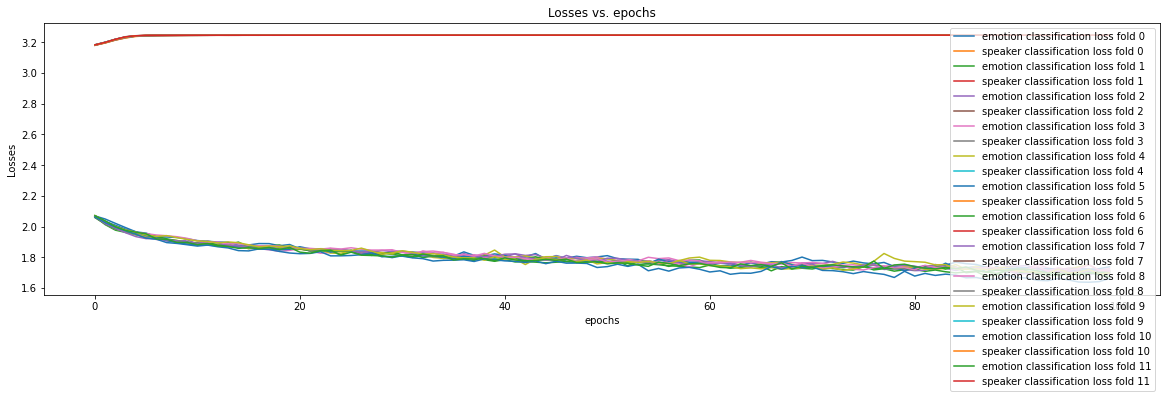

In [14]:
plt.figure(figsize=(20,5))
plt.title('Losses vs. epochs')
plt.xlabel('epochs')
plt.ylabel('Losses')

for i in range(FOLDS):
    plt.plot(range(EPOCHS), fold_emotion_class_losses[i],label='emotion classification loss fold {}'.format(i))
    plt.plot(range(EPOCHS), fold_speaker_class_losses[i],label='speaker classification loss fold {}'.format(i))

plt.legend(loc='best')
plt.show() 

In [15]:
def plot_accuracies_vs_epochs(fold):
    plt.figure(figsize=(20,5))
    plt.title('Accuracies vs. epochs')
    plt.xlabel('epochs')
    plt.ylabel('Losses')
    plt.plot(range(EPOCHS), fold_emotion_training_accuracies[fold],label='emotion_training_accuracies fold {}'.format(fold))
    plt.plot(range(EPOCHS), fold_emotion_validating_accuracies[fold],label='emotion_validating_accuracies fold {}'.format(fold))
    plt.plot(range(EPOCHS), fold_speaker_training_accuracies[fold],label='speaker_training_accuracies fold {}'.format(fold))
    plt.plot(range(EPOCHS), fold_speaker_validating_accuracies[fold],label='speaker_validating_accuracies fold {}'.format(fold))
    plt.legend(loc='best')
    plt.show() 
    print("Maximum emotion training accuracy:{:.2f}%".format(max(fold_emotion_training_accuracies[fold])*100))
    print("Maximum emotion validating accuracy:{:.2f}%".format(max(fold_emotion_validating_accuracies[fold])*100))
    print("Maximum speaker training accuracy:{:.2f}%".format(max(fold_speaker_training_accuracies[fold])*100))
    print("Maximum speaker validating accuracy:{:.2f}%".format(max(fold_speaker_validating_accuracies[fold])*100))

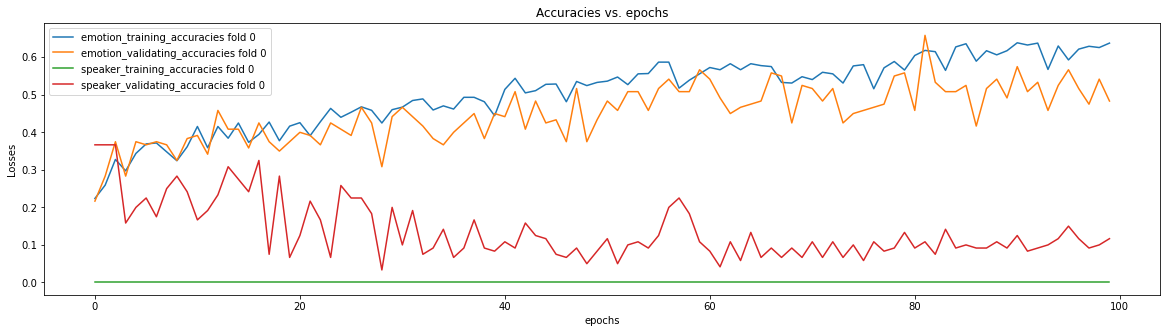

Maximum emotion training accuracy:63.85%
Maximum emotion validating accuracy:65.83%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:36.67%


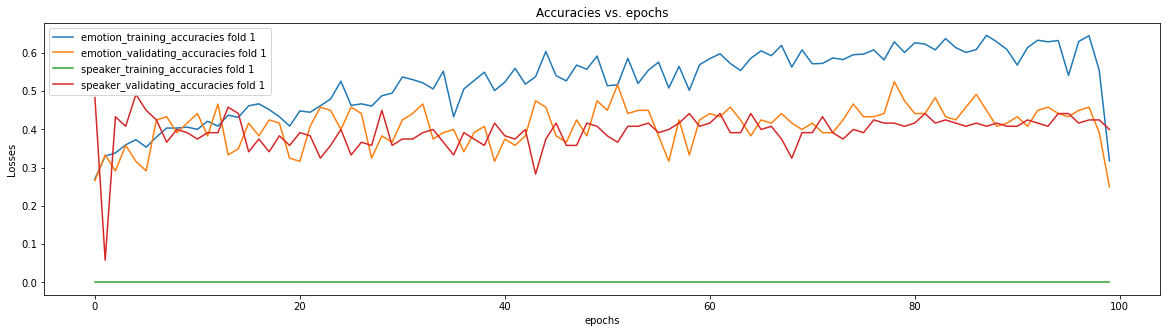

Maximum emotion training accuracy:64.61%
Maximum emotion validating accuracy:52.50%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:49.17%


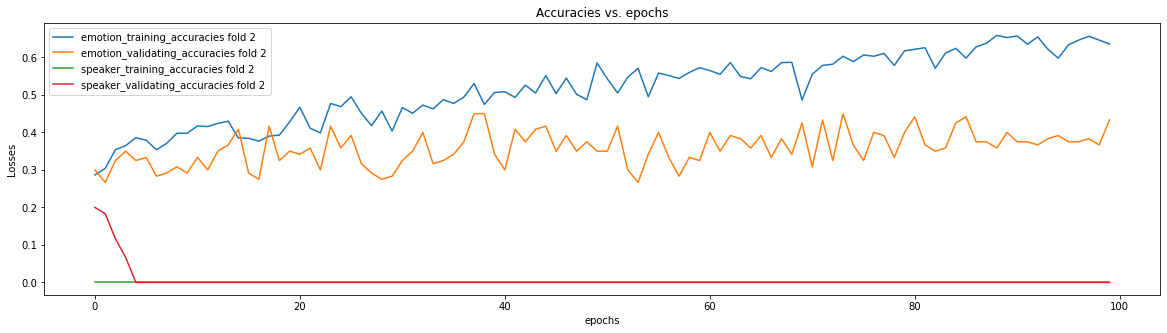

Maximum emotion training accuracy:65.88%
Maximum emotion validating accuracy:45.00%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:20.00%


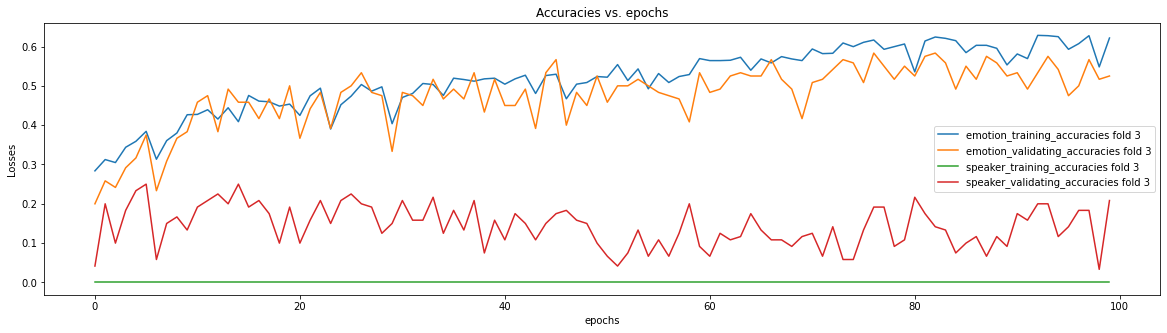

Maximum emotion training accuracy:62.84%
Maximum emotion validating accuracy:58.33%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:25.00%


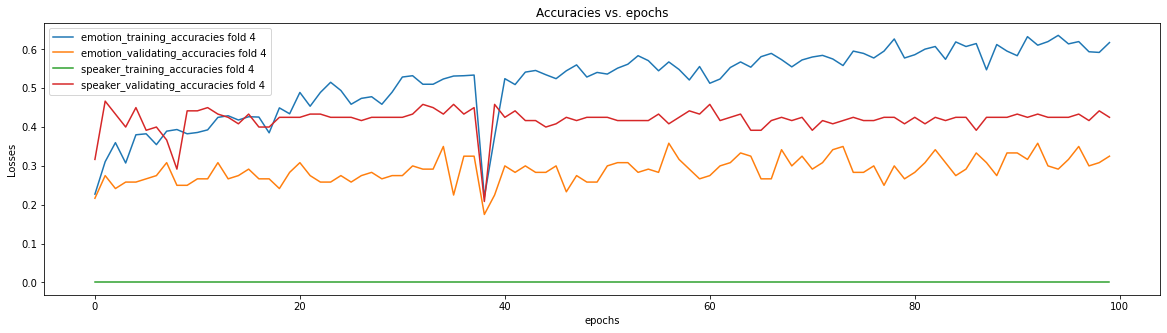

Maximum emotion training accuracy:63.60%
Maximum emotion validating accuracy:35.83%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:46.67%


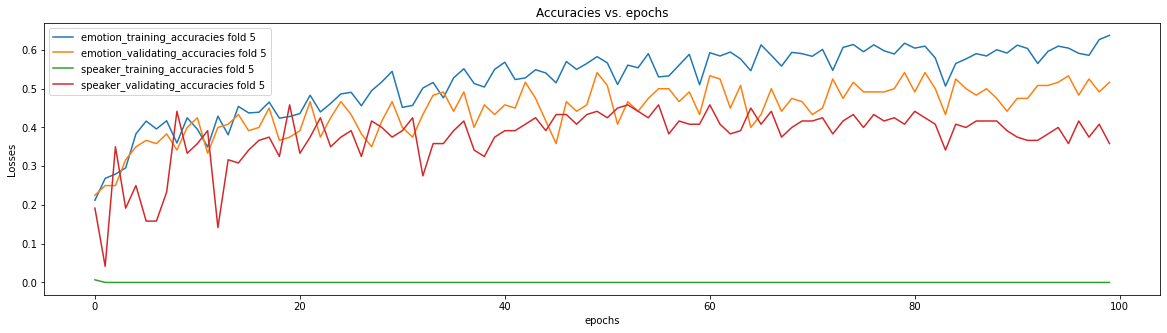

Maximum emotion training accuracy:63.77%
Maximum emotion validating accuracy:54.17%
Maximum speaker training accuracy:0.68%
Maximum speaker validating accuracy:45.83%


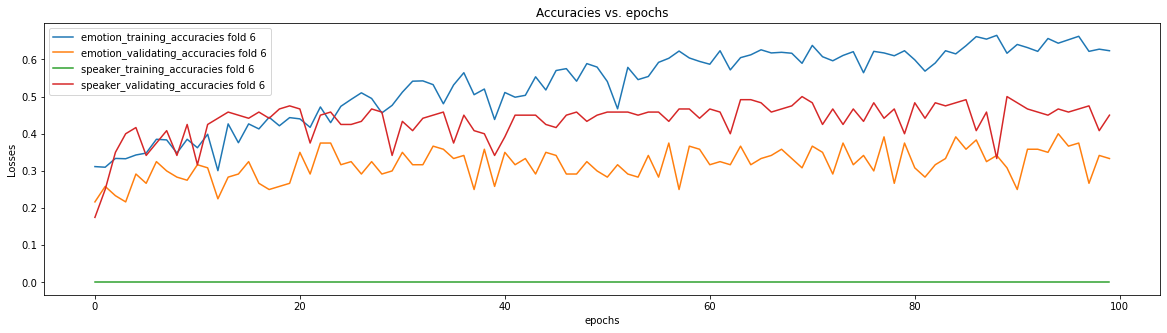

Maximum emotion training accuracy:66.47%
Maximum emotion validating accuracy:40.00%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:50.00%


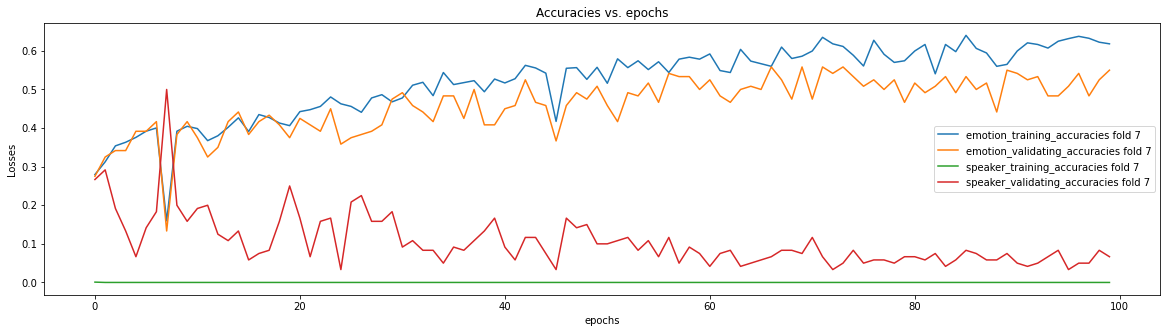

Maximum emotion training accuracy:64.02%
Maximum emotion validating accuracy:55.83%
Maximum speaker training accuracy:0.08%
Maximum speaker validating accuracy:50.00%


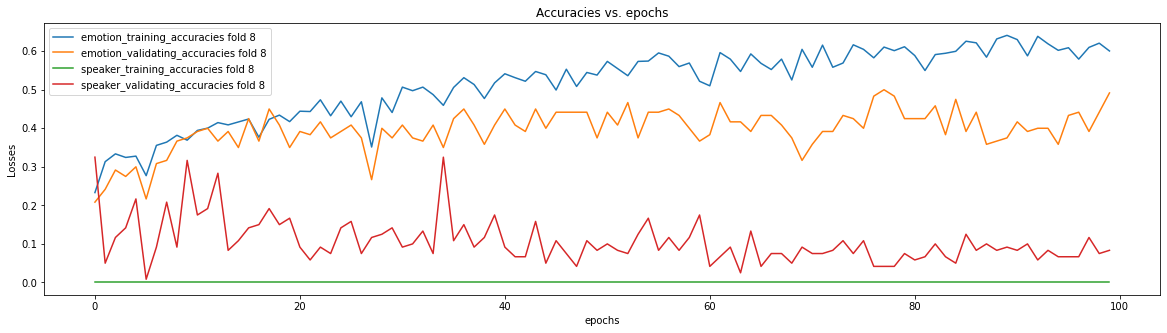

Maximum emotion training accuracy:64.10%
Maximum emotion validating accuracy:50.00%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:32.50%


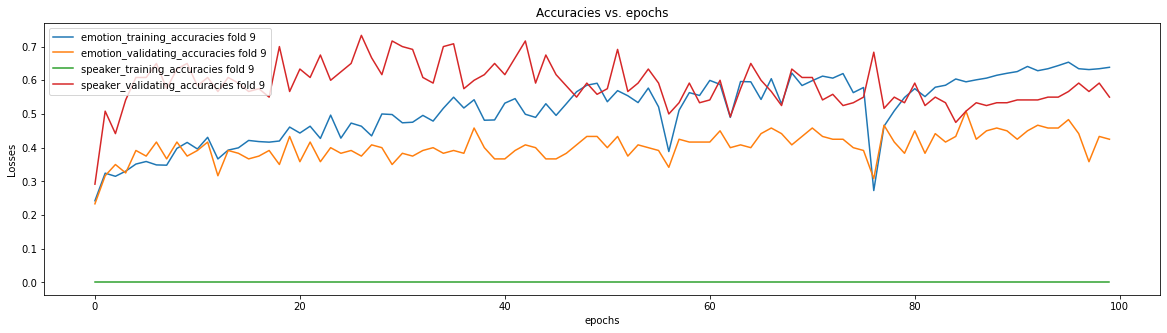

Maximum emotion training accuracy:65.37%
Maximum emotion validating accuracy:50.83%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:73.33%


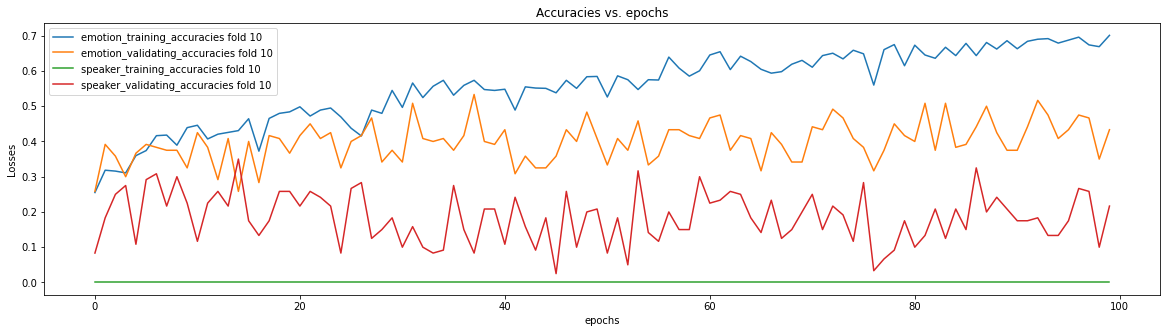

Maximum emotion training accuracy:70.10%
Maximum emotion validating accuracy:53.33%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:35.00%


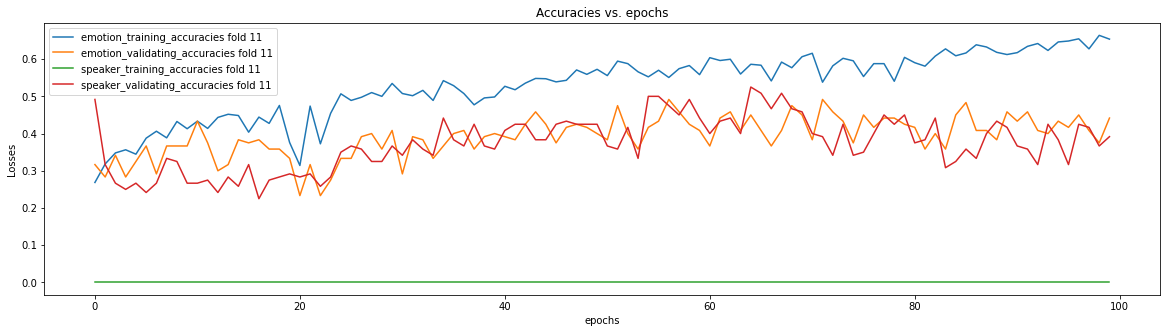

Maximum emotion training accuracy:66.39%
Maximum emotion validating accuracy:49.17%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:52.50%


In [16]:
for i in range(FOLDS):
    plot_accuracies_vs_epochs(i)

## 5. Loading and evaluating the model

In [17]:
import warnings
warnings.filterwarnings('ignore')
from statistics import mean , stdev
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"

lfold_emotion_training_accuracies, lfold_emotion_validating_accuracies, lfold_emotion_testing_accuracies = [] , [] , []
lfold_speaker_training_accuracies, lfold_speaker_validating_accuracies, lfold_speaker_testing_accuracies = [] , [] , []

for fold in range(12):
    print("\nEvaluation for fold {}".format(fold))
    checkpoint = torch.load(MODEL_PATH + 'fold' + str(fold))
    
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # DEVICE = torch.device("cpu")

    encoder = FeatureExtractor().to(DEVICE).train()
    emotion_classifier = EmotionClassifier().to(DEVICE).train()
    speaker_classifier = SpeakerClassifier().to(DEVICE)
    
    encoder = nn.DataParallel(encoder)
    emotion_classifier = nn.DataParallel(emotion_classifier)
    speaker_classifier = nn.DataParallel(speaker_classifier)

    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    emotion_optimizer = torch.optim.Adam(emotion_classifier.parameters())
    speaker_optimizer = torch.optim.Adam(speaker_classifier.parameters())
    
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    emotion_classifier.load_state_dict(checkpoint['emotion_classifier_state_dict'])
    speaker_classifier.load_state_dict(checkpoint['speaker_classifier_state_dict'])
    
    encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
    emotion_optimizer.load_state_dict(checkpoint['emotion_optimizer_state_dict'])
    speaker_optimizer.load_state_dict(checkpoint['speaker_optimizer_state_dict'])
    
    ravdess_dataset_train = RavdessDataset2(ROOT,cv_index = fold ,split= 'train')
    ravdess_dataset_test = RavdessDataset2(ROOT,cv_index = fold, split= 'test')
    ravdess_dataset_validate = RavdessDataset2(ROOT,cv_index = fold, split= 'validate')
    
    TRAIN_BATCH_SIZE = len(ravdess_dataset_train)
    VALIDATE_BATCH_SIZE = len(ravdess_dataset_validate)
    TEST_BATCH_SIZE = len(ravdess_dataset_test)
    
    ravdess_train_loader = DataLoader(dataset=ravdess_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    ravdess_validate_loader = DataLoader(dataset=ravdess_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    ravdess_test_loader = DataLoader(dataset=ravdess_dataset_test, batch_size= TEST_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    
    encoder.eval()
    emotion_classifier.eval()

    lemotion_training_correct, lemotion_validating_correct, lemotion_testing_correct = 0 , 0 , 0
    lspeaker_training_correct, lspeaker_validating_correct, lspeaker_testing_correct = 0 , 0 , 0

    with torch.no_grad():
        

#         # 1. Training Classification
#         for index, (features, emotion, speaker) in enumerate(ravdess_train_loader):
#             features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
#             conv_features = encoder(features)
#             emotion_output = emotion_classifier(conv_features)
#             speaker_output = speaker_classifier(conv_features)
#             _, emotion_preds = torch.max(emotion_output,1)
#             _, speaker_preds = torch.max(speaker_output,1)
#             lemotion_training_correct += (emotion_preds == emotion).sum() 
#             lspeaker_training_correct += (speaker_preds == speaker).sum()
#         emotion_training_accuracy = lemotion_training_correct.item()/(len(ravdess_train_loader)*TRAIN_BATCH_SIZE)
#         speaker_training_accuracy = lspeaker_training_correct.item()/(len(ravdess_train_loader)*TRAIN_BATCH_SIZE)
#         print("\nEmotion Training Correct: {}/{} \nEmotion Training Accuracy: {:.5f}%".format(lemotion_training_correct,(len(ravdess_train_loader)*TRAIN_BATCH_SIZE),emotion_training_accuracy*100))
#         print("Speaker Training Correct: {}/{} \nSpeaker Training Accuracy: {:.5f}%".format(lspeaker_training_correct,(len(ravdess_train_loader)*TRAIN_BATCH_SIZE),speaker_training_accuracy*100)) 
        
        # 2. Validating Classification
        for index, (features, emotion, speaker) in enumerate(ravdess_validate_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            lemotion_validating_correct += (emotion_preds == emotion).sum() 
            lspeaker_validating_correct += (speaker_preds == speaker).sum()
        emotion_validating_accuracy = lemotion_validating_correct.item()/(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE)
        speaker_validating_accuracy = lspeaker_validating_correct.item()/(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE)
        print("\nEmotion Validating Correct: {}/{} \nEmotion Validating Accuracy: {:.5f}%".format(lemotion_validating_correct,(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE),emotion_validating_accuracy*100))
#         print("Speaker Validating Correct: {}/{} \nSpeaker Validating Accuracy: {:.5f}%".format(lspeaker_validating_correct,(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE),speaker_validating_accuracy*100)) 
        

        # 3. Testing Classification
        for index, (features, emotion, speaker) in enumerate(ravdess_test_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            lemotion_testing_correct += (emotion_preds == emotion).sum() 
            lspeaker_testing_correct += (speaker_preds == speaker).sum()
        emotion_testing_accuracy = lemotion_testing_correct.item()/(len(ravdess_test_loader)*TEST_BATCH_SIZE)
        speaker_testing_accuracy = lspeaker_testing_correct.item()/(len(ravdess_test_loader)*TEST_BATCH_SIZE)
        print("\nEmotion Testing Correct: {}/{} \nEmotion Testing Accuracy: {:.5f}%".format(lemotion_testing_correct,(len(ravdess_test_loader)*TEST_BATCH_SIZE),emotion_testing_accuracy*100))
#         print("Speaker Testing Correct: {}/{} \nSpeaker Testing Accuracy: {:.5f}%".format(lspeaker_testing_correct,(len(ravdess_test_loader)*TEST_BATCH_SIZE),speaker_testing_accuracy*100)) 

#         lfold_emotion_training_accuracies.append(emotion_training_accuracy)
        lfold_emotion_validating_accuracies.append(emotion_validating_accuracy)
        lfold_emotion_testing_accuracies.append(emotion_testing_accuracy)
#         lfold_speaker_training_accuracies.append(speaker_training_accuracy)
#         lfold_speaker_validating_accuracies.append(speaker_validating_accuracy)
#         lfold_speaker_testing_accuracies.append(speaker_testing_accuracy)

print('\nSUMMARY:')
# print('\nCV Emotion Training accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_training_accuracies), stdev(lfold_emotion_training_accuracies)))
print('\nCV Emotion Validating accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_validating_accuracies), stdev(lfold_emotion_validating_accuracies)))
print('\nCV Emotion Testing accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_testing_accuracies), stdev(lfold_emotion_testing_accuracies)))

# print('\nCV Speaker Training accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_speaker_training_accuracies), stdev(lfold_speaker_training_accuracies)))
# print('\nCV Speaker Validating accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_speaker_validating_accuracies), stdev(lfold_speaker_validating_accuracies)))
# print('\nCV Speaker Testing accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_speaker_testing_accuracies), stdev(lfold_speaker_testing_accuracies)))


Evaluation for fold 0



Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%



Emotion Testing Correct: 55/120 
Emotion Testing Accuracy: 45.83333%

Evaluation for fold 1



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%



Emotion Testing Correct: 45/120 
Emotion Testing Accuracy: 37.50000%

Evaluation for fold 2



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%



Emotion Testing Correct: 53/120 
Emotion Testing Accuracy: 44.16667%

Evaluation for fold 3



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%



Emotion Testing Correct: 47/120 
Emotion Testing Accuracy: 39.16667%

Evaluation for fold 4



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%



Emotion Testing Correct: 59/120 
Emotion Testing Accuracy: 49.16667%

Evaluation for fold 5



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%



Emotion Testing Correct: 48/120 
Emotion Testing Accuracy: 40.00000%

Evaluation for fold 6



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%



Emotion Testing Correct: 65/120 
Emotion Testing Accuracy: 54.16667%

Evaluation for fold 7



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%



Emotion Testing Correct: 51/120 
Emotion Testing Accuracy: 42.50000%

Evaluation for fold 8



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%



Emotion Testing Correct: 60/120 
Emotion Testing Accuracy: 50.00000%

Evaluation for fold 9



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%



Emotion Testing Correct: 56/120 
Emotion Testing Accuracy: 46.66667%

Evaluation for fold 10



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%



Emotion Testing Correct: 56/120 
Emotion Testing Accuracy: 46.66667%

Evaluation for fold 11



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%



Emotion Testing Correct: 56/120 
Emotion Testing Accuracy: 46.66667%

SUMMARY:

CV Emotion Validating accuracies 
Mean: 0.5090277777777777 
S.D: 0.08012445601174745

CV Emotion Testing accuracies 
Mean: 0.45208333333333334 
S.D: 0.04834704612162845
